In [1]:
#Cell 0 - Project Root Detection
# Allows running from subdirectories like notebooks_v2/
import sys
from pathlib import Path

def find_project_root(marker_files=('common/__init__.py', 'prompts')):
    """Find project root by looking for marker files, searching up from cwd."""
    current = Path().absolute()
    for parent in [current] + list(current.parents):
        for marker in marker_files:
            if (parent / marker).exists():
                return parent
    return current  # Fallback to cwd if no marker found

# Detect project root (works from any subdirectory)
PROJECT_ROOT = find_project_root()
print(f"📂 Current directory: {Path().absolute()}")
print(f"🏠 Project root: {PROJECT_ROOT}")

# Ensure the project root is in the Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    print(f"✅ Added {PROJECT_ROOT} to sys.path")

print("✅ Project root detection complete")

📂 Current directory: /Users/tod/Desktop/LMM_POC/notebooks_v2
🏠 Project root: /Users/tod/Desktop/LMM_POC
✅ Added /Users/tod/Desktop/LMM_POC to sys.path
✅ Project root detection complete


# Model Comparison V2: Llama vs InternVL3 vs InternVL3.5

**V2 Batch Processing Performance Analysis - Sophisticated Bank Statement Extraction**

---

This notebook provides a comprehensive comparison of three vision-language models using the V2 batch processing notebooks with sophisticated multi-turn bank statement extraction:

| Model | Notebook | Key Features |
|-------|----------|--------------|
| **Llama-3.2-Vision-11B** | `llama_batch_v2.ipynb` | Multi-turn bank extraction, bfloat16 |
| **InternVL3.5-8B** | `ivl3_5_8b_batch_v2.ipynb` | Multi-turn bank extraction, bfloat16, Cascade RL |
| **InternVL3-2B** | `ivl3_2b_batch_v2.ipynb` | Multi-turn bank extraction, bfloat16 |

## V2 Features:
- **Sophisticated bank statement extraction** using UnifiedBankExtractor
- Turn 0: Header detection (identifies actual column names)
- Turn 1: Adaptive extraction with structure-dynamic prompts
- Automatic strategy selection: BALANCE_DESCRIPTION, AMOUNT_DESCRIPTION, etc.
- Optional balance-based mathematical correction

## Key Business Questions Addressed:
1. **Accuracy**: Which model extracts information more reliably?
2. **Bank Statement Performance**: How does V2 multi-turn extraction improve bank statement accuracy?
3. **Speed**: Which model processes documents faster?
4. **Document Type Performance**: How do models perform on invoices, receipts, and bank statements?
5. **Production Readiness**: Which model is recommended for deployment?

## 1. Setup and Configuration

In [2]:
# Cell 2

import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from rich import print as rprint
from rich.console import Console

warnings.filterwarnings('ignore')
console = Console()

# Set professional styling for executive presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ============================================================================
# CONFIGURATION - Edit these values to configure the comparison
# ============================================================================

# Base path for data files
# base_data_path = '/home/jovyan/nfs_share/tod/LMM_POC'
base_data_path = '/Users/tod/Desktop/LMM_POC'

CONFIG = {
    # Path settings
    'output_dir': f'{base_data_path}/output/csv',
    'ground_truth_path': f'{base_data_path}/evaluation_data/synthetic/ground_truth_synthetic.csv',
    
    # ============================================================================
    # MODEL CONFIGURATIONS - Explicit file paths and display names
    # ============================================================================
    # Edit these to specify exact files and customize display names
    # Set 'file' to None to skip a model
    # ============================================================================
    'models': {
        'llama': {
            'file': 'llama_batch_results_20251210_003155.csv',
            'display_name': 'Llama-11B',
            'color': '#3498db'  # Blue
        },
        'internvl3_8b': {
            'file': 'internvl3_batch_results_20251210_005902.csv',
            'display_name': 'IVL3.5-8B',
            'color': '#e74c3c'  # Red
        },
        'internvl3_2b': {
            'file': 'internvl3_2b_batch_results_20251210_013149.csv',
            'display_name': 'IVL3-2B',
            'color': '#2ecc71'  # Green
        }
    },
    
    # Visualization settings
    'figure_size': (16, 10),
    'dpi': 600,
    'save_format': 'png'
}

# ============================================================================
# Display configuration summary
# ============================================================================
print("✅ Model comparison V2 configuration loaded")
print(f"📁 Output directory: {CONFIG['output_dir']}")
print(f"📊 Ground truth: {CONFIG['ground_truth_path']}")
print(f"\n🔧 Model configurations:")
for key, model_cfg in CONFIG['models'].items():
    if model_cfg['file']:
        print(f"   • {model_cfg['display_name']}: {model_cfg['file']}")
    else:
        print(f"   • {key}: (skipped - file is None)")

✅ Model comparison V2 configuration loaded
📁 Output directory: /Users/tod/Desktop/LMM_POC/output/csv
📊 Ground truth: /Users/tod/Desktop/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv

🔧 Model configurations:
   • Llama-11B: llama_batch_results_20251210_003155.csv
   • IVL3.5-8B: internvl3_batch_results_20251210_005902.csv
   • IVL3-2B: internvl3_2b_batch_results_20251210_013149.csv


## 2. Data Loading and Preparation

In [3]:
# Cell 4

def load_model_results(output_dir: str, filename: str, display_name: str) -> pd.DataFrame:
    """
    Load results from an explicit CSV file path.
    
    Args:
        output_dir: Directory containing the file
        filename: Exact filename to load
        display_name: Display name for the model (used in 'model' column)
        
    Returns:
        DataFrame with results, or empty DataFrame if file not found
    """
    from pathlib import Path
    
    file_path = Path(output_dir) / filename
    
    if not file_path.exists():
        rprint(f"[red]❌ File not found: {file_path}[/red]")
        return pd.DataFrame()
    
    rprint(f"[green]✅ Loading {display_name} from: {filename}[/green]")
    
    try:
        df = pd.read_csv(file_path)
        
        # Add model column with display name
        df['model'] = display_name
        
        # Ensure required columns exist
        required_cols = ['overall_accuracy', 'processing_time', 'document_type']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            rprint(f"[yellow]⚠️ Missing columns in {display_name} data: {missing_cols}[/yellow]")
            for col in missing_cols:
                if col == 'overall_accuracy':
                    df[col] = 0.0
                elif col == 'processing_time':
                    df[col] = 1.0
                elif col == 'document_type':
                    df[col] = 'unknown'
        
        rprint(f"[dim]   Loaded {len(df)} records[/dim]")
        return df
        
    except Exception as e:
        rprint(f"[red]❌ Error loading {display_name}: {e}[/red]")
        return pd.DataFrame()

# ============================================================================
# Load all configured models
# ============================================================================
rprint("[bold blue]📊 Loading Model Results[/bold blue]\n")

model_dataframes = {}
for model_key, model_cfg in CONFIG['models'].items():
    if model_cfg['file']:
        df = load_model_results(
            CONFIG['output_dir'],
            model_cfg['file'],
            model_cfg['display_name']
        )
        if not df.empty:
            model_dataframes[model_key] = df

# Create individual named dataframes for backward compatibility
llama_batch_df = model_dataframes.get('llama', pd.DataFrame())
internvl_batch_df = model_dataframes.get('internvl3_8b', pd.DataFrame())
internvl_nq_batch_df = model_dataframes.get('internvl3_2b', pd.DataFrame())

# Combine all loaded models
if model_dataframes:
    combined_df = pd.concat(model_dataframes.values(), ignore_index=True)
    print(f"\n✅ Combined {len(combined_df)} total records from {len(model_dataframes)} models")
else:
    combined_df = pd.DataFrame()
    rprint("[red]❌ No model data loaded![/red]")

# Build color map from config
MODEL_COLORS = {
    cfg['display_name']: cfg['color'] 
    for cfg in CONFIG['models'].values() 
    if cfg['file']
}

# Backward compatibility aliases (some cells use these names)
llama_df = llama_batch_df
internvl3_8b_df = internvl_batch_df
internvl3_2b_df = internvl_nq_batch_df

📊 Loading Model Results

✅ Loading Llama-11B from: llama_batch_results_20251210_003155.csv

   Loaded 9 records

✅ Loading IVL3.5-8B from: internvl3_batch_results_20251210_005902.csv

   Loaded 9 records

✅ Loading IVL3-2B from: internvl3_2b_batch_results_20251210_013149.csv

   Loaded 9 records


✅ Combined 27 total records from 3 models


In [4]:
# Cell 5

# Display loaded data summary (data was loaded in previous cell)
rprint("[bold blue]📊 V2 Model Performance Data Summary[/bold blue]")
rprint("[cyan]V2 notebooks use sophisticated multi-turn bank statement extraction[/cyan]\n")

if not combined_df.empty:
    # Show what models were loaded
    loaded_models = combined_df['model'].unique()
    rprint(f"[green]✅ {len(loaded_models)} models loaded with {len(combined_df)} total records[/green]")
    
    # Show record counts per model
    for model in loaded_models:
        count = len(combined_df[combined_df['model'] == model])
        rprint(f"   • {model}: {count} records")
    
    # Show column summary
    rprint(f"\n[dim]Columns: {', '.join(combined_df.columns[:10])}{'...' if len(combined_df.columns) > 10 else ''}[/dim]")
else:
    rprint("[red]❌ No data loaded[/red]")
    rprint("\n[yellow]💡 Check CONFIG['models'] in the configuration cell above[/yellow]")

📊 V2 Model Performance Data Summary

V2 notebooks use sophisticated multi-turn bank statement extraction

✅ 3 models loaded with 27 total records

• Llama-11B: 9 records

• IVL3.5-8B: 9 records

• IVL3-2B: 9 records

Columns: image_file, image_name, document_type, processing_time, field_count, found_fields, field_coverage, 
prompt_used, timestamp, overall_accuracy...

In [5]:
# Cell: Compute Per-Model Mean F1 (Position-Aware)
# This cell computes Mean F1 for each model BEFORE the dashboards
# so that dashboards can display F1 instead of document-level accuracy.

import sys
from pathlib import Path

# Add project root to path for imports
PROJECT_ROOT = Path(CONFIG['output_dir']).parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

from common.evaluation_metrics import calculate_field_accuracy_f1

# Define field columns for F1 computation
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS',
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID'
]

# Load ground truth for F1 computation
ground_truth_path = Path(CONFIG['ground_truth_path'])
if ground_truth_path.exists():
    ground_truth = pd.read_csv(ground_truth_path, dtype=str)
    # Normalize column names
    if 'image_name' in ground_truth.columns and 'image_file' not in ground_truth.columns:
        ground_truth['image_file'] = ground_truth['image_name']
    ground_truth['image_stem'] = ground_truth['image_file'].apply(lambda x: Path(x).stem)
    rprint(f"[green]✅ Ground truth loaded: {len(ground_truth)} rows[/green]")
else:
    ground_truth = pd.DataFrame()
    rprint(f"[red]❌ Ground truth not found: {ground_truth_path}[/red]")


def compute_model_mean_f1(batch_df: pd.DataFrame, gt_df: pd.DataFrame, model_name: str) -> float:
    """
    Compute Mean F1 across all fields for a model using position-aware matching.
    
    This is the SAME calculation used in model_accuracy_comparison.ipynb
    for comparing against LayoutLM.
    
    Returns:
        Mean F1 score (0-1 scale)
    """
    if batch_df.empty or gt_df.empty:
        return 0.0
    
    # Add image_stem for matching
    if 'image_stem' not in batch_df.columns:
        batch_df = batch_df.copy()
        batch_df['image_stem'] = batch_df['image_file'].apply(lambda x: Path(x).stem)
    
    field_f1_scores = []
    
    for field in FIELD_COLUMNS:
        if field not in batch_df.columns or field not in gt_df.columns:
            continue
        
        # Merge on image_stem
        merged = batch_df.merge(
            gt_df[['image_stem', field]],
            on='image_stem',
            how='inner',
            suffixes=('_pred', '_true')
        )
        
        if len(merged) == 0:
            continue
        
        pred_col = f'{field}_pred' if f'{field}_pred' in merged.columns else field
        true_col = f'{field}_true' if f'{field}_true' in merged.columns else field
        
        # Compute F1 for each document, then average
        doc_f1_scores = []
        for _, row in merged.iterrows():
            pred_val = str(row[pred_col]) if pd.notna(row[pred_col]) else 'NOT_FOUND'
            true_val = str(row[true_col]) if pd.notna(row[true_col]) else 'NOT_FOUND'
            metrics = calculate_field_accuracy_f1(pred_val, true_val, field, debug=False)
            doc_f1_scores.append(metrics['f1_score'])
        
        if doc_f1_scores:
            field_f1_scores.append(sum(doc_f1_scores) / len(doc_f1_scores))
    
    if field_f1_scores:
        return sum(field_f1_scores) / len(field_f1_scores)
    return 0.0


# Compute Mean F1 for each model
rprint("\n[bold cyan]Computing Mean F1 (Position-Aware) for each model...[/bold cyan]")

model_mean_f1 = {}

# Use CONFIG display names as keys so they match the dashboard
if not llama_df.empty and not ground_truth.empty:
    llama_name = CONFIG['models']['llama']['display_name']
    model_mean_f1[llama_name] = compute_model_mean_f1(llama_df, ground_truth, llama_name)
    rprint(f"  {llama_name} Mean F1: {model_mean_f1[llama_name]:.1%}")

if not internvl3_8b_df.empty and not ground_truth.empty:
    ivl8b_name = CONFIG['models']['internvl3_8b']['display_name']
    model_mean_f1[ivl8b_name] = compute_model_mean_f1(internvl3_8b_df, ground_truth, ivl8b_name)
    rprint(f"  {ivl8b_name} Mean F1: {model_mean_f1[ivl8b_name]:.1%}")

if not internvl3_2b_df.empty and not ground_truth.empty:
    ivl2b_name = CONFIG['models']['internvl3_2b']['display_name']
    model_mean_f1[ivl2b_name] = compute_model_mean_f1(internvl3_2b_df, ground_truth, ivl2b_name)
    rprint(f"  {ivl2b_name} Mean F1: {model_mean_f1[ivl2b_name]:.1%}")

# Add mean_f1 column to combined_df for dashboard use
if not combined_df.empty and model_mean_f1:
    combined_df['mean_f1'] = combined_df['model'].map(model_mean_f1)
    # Also add per-document F1 (approximation using overall_accuracy scaled by model mean F1 ratio)
    # This preserves relative document performance while using F1 scale
    for model_name in combined_df['model'].unique():
        if model_name in model_mean_f1:
            mask = combined_df['model'] == model_name
            model_acc_mean = combined_df.loc[mask, 'overall_accuracy'].mean()
            if model_acc_mean > 0:
                # Scale factor to convert accuracy to F1 scale
                scale = model_mean_f1[model_name] / (model_acc_mean / 100.0)
                combined_df.loc[mask, 'mean_f1_scaled'] = combined_df.loc[mask, 'overall_accuracy'] / 100.0 * scale
    rprint(f"\n[green]✅ Added mean_f1 column to combined_df[/green]")

rprint("\n[bold green]✅ F1 computation complete - dashboards will use Mean F1[/bold green]")


DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES'], 'transaction_list': ['TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']


✅ Ground truth loaded: 9 rows

Computing Mean F1 (Position-Aware) for each model...

Llama-11B Mean F1: 98.2%

IVL3.5-8B Mean F1: 94.4%

IVL3-2B Mean F1: 84.2%

✅ Added mean_f1 column to combined_df

✅ F1 computation complete - dashboards will use Mean F1

In [6]:
# Cell 6

def generate_executive_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate executive summary statistics from combined model data.
    
    Args:
        df: Combined DataFrame with all model results
        
    Returns:
        DataFrame with summary statistics per model (including both mean and median)
    """
    if df.empty:
        return pd.DataFrame()
    
    summary_stats = df.groupby('model').agg({
        'overall_accuracy': ['mean', 'median', 'std', 'min', 'max'],
        'processing_time': ['mean', 'median', 'std', 'min', 'max'],
        'fields_extracted': 'mean',
        'fields_matched': 'mean'
    }).round(2)
    
    # Flatten column names
    summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
    
    # Calculate throughput (documents per minute) using median time
    summary_stats['throughput_docs_per_min'] = (60 / summary_stats['processing_time_median']).round(2)
    
    # Calculate efficiency score (accuracy × throughput) using mean accuracy
    summary_stats['efficiency_score'] = (summary_stats['overall_accuracy_mean'] * summary_stats['throughput_docs_per_min']).round(2)
    
    return summary_stats.reset_index()

📊 Creating Executive Dashboard

✅ Executive dashboard saved to: /Users/tod/Desktop/LMM_POC/output/visualizations/executive_comparison.png

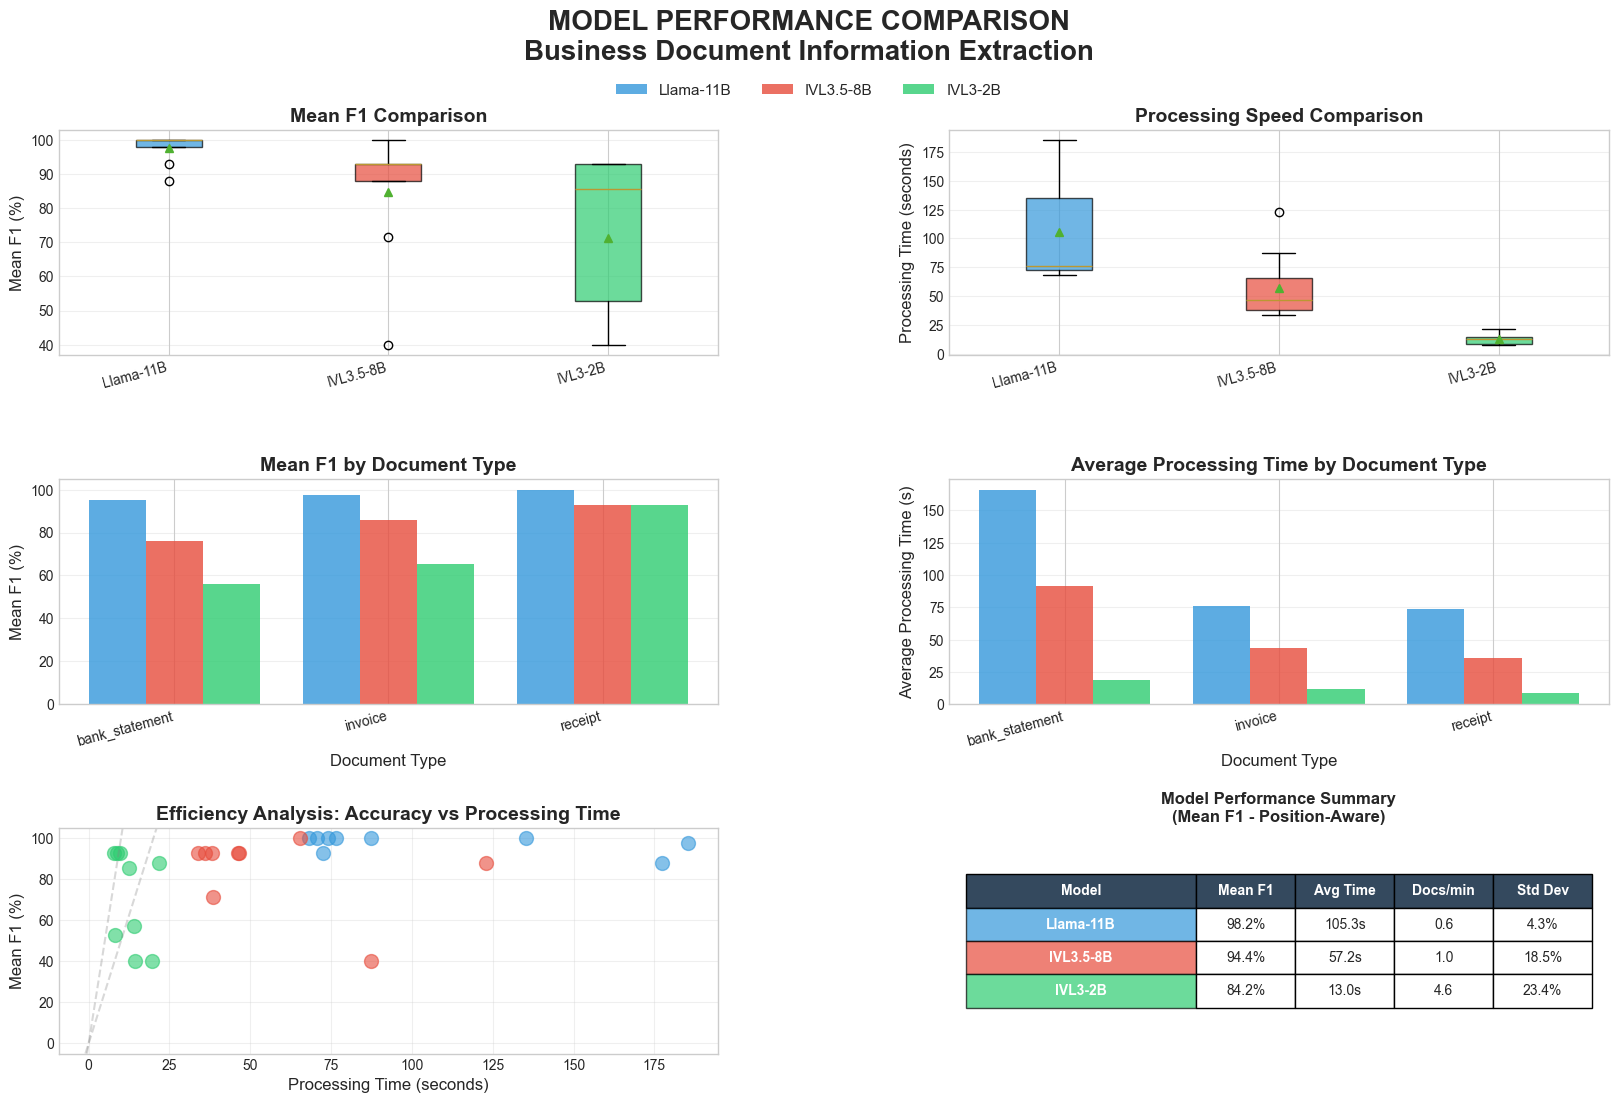

✅ Executive dashboard created successfully

In [7]:
# Cell 7

def create_executive_dashboard(df: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive 6-panel executive dashboard comparing model performance.
    
    Args:
        df: Combined DataFrame with results from all models
        save_path: Optional path to save the visualization
    """
    if df.empty:
        rprint("[red]❌ Cannot create dashboard - no data available[/red]")
        return
    
    # Define model order and colors for consistency
    # Derive model names and colors from CONFIG for true configurability
    model_order = [CONFIG['models'][key]['display_name'] for key in CONFIG['models']]
    fixed_colors = {CONFIG['models'][key]['display_name']: CONFIG['models'][key]['color'] 
                    for key in CONFIG['models']}
    
    # Filter to only available models and maintain order
    available_models = df['model'].unique()
    models = [model for model in model_order if model in available_models]
    model_colors = [fixed_colors[model] for model in models if model in fixed_colors]
    
    # Create figure with 6 subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.55, wspace=0.35)
    
    # 1. Overall Accuracy Comparison (Box Plot)
    ax1 = fig.add_subplot(gs[0, 0])
    df_plot = df[df['model'].isin(models)]
    
    box_parts = ax1.boxplot(
        [df_plot[df_plot['model'] == model]['overall_accuracy'].values for model in models],
        labels=models,
        patch_artist=True,
        showmeans=True
    )
    
    for patch, color in zip(box_parts['boxes'], model_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Mean F1 (%)', fontsize=12)
    ax1.set_title('Mean F1 Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticklabels(models, rotation=15, ha='right')
    
    # 2. Processing Speed Comparison (Box Plot)
    ax2 = fig.add_subplot(gs[0, 1])
    
    box_parts = ax2.boxplot(
        [df_plot[df_plot['model'] == model]['processing_time'].values for model in models],
        labels=models,
        patch_artist=True,
        showmeans=True
    )
    
    for patch, color in zip(box_parts['boxes'], model_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Processing Time (seconds)', fontsize=12)
    ax2.set_title('Processing Speed Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticklabels(models, rotation=15, ha='right')
    
    # 3. Average Accuracy by Document Type (Grouped Bar Chart)
    ax3 = fig.add_subplot(gs[1, 0])
    
    doc_accuracy = df_plot.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
    doc_accuracy = doc_accuracy[models]  # Ensure correct order
    
    x = np.arange(len(doc_accuracy.index))
    width = 0.8 / len(models)
    
    for idx, model in enumerate(models):
        offset = (idx - len(models)/2 + 0.5) * width
        ax3.bar(x + offset, doc_accuracy[model], width, 
               label=model, color=fixed_colors[model], alpha=0.8)
    
    ax3.set_ylabel('Mean F1 (%)', fontsize=12)
    ax3.set_xlabel('Document Type', fontsize=12)
    ax3.set_title('Mean F1 by Document Type', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(doc_accuracy.index, rotation=15, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Average Processing Time by Document Type (Grouped Bar Chart)
    ax4 = fig.add_subplot(gs[1, 1])
    
    doc_time = df_plot.groupby(['document_type', 'model'])['processing_time'].mean().unstack()
    doc_time = doc_time[models]  # Ensure correct order
    
    for idx, model in enumerate(models):
        offset = (idx - len(models)/2 + 0.5) * width
        ax4.bar(x + offset, doc_time[model], width,
               label=model, color=fixed_colors[model], alpha=0.8)
    
    ax4.set_ylabel('Average Processing Time (s)', fontsize=12)
    ax4.set_xlabel('Document Type', fontsize=12)
    ax4.set_title('Average Processing Time by Document Type', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(doc_time.index, rotation=15, ha='right')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Efficiency Analysis: Accuracy vs Processing Time (Scatter Plot)
    ax5 = fig.add_subplot(gs[2, 0])
    
    for model in models:
        model_data = df_plot[df_plot['model'] == model]
        ax5.scatter(model_data['processing_time'], model_data['overall_accuracy'],
                   label=model, color=fixed_colors[model], alpha=0.6, s=100)
    
    ax5.set_xlabel('Processing Time (seconds)', fontsize=12)
    ax5.set_ylabel('Mean F1 (%)', fontsize=12)
    ax5.set_title('Efficiency Analysis: Accuracy vs Processing Time', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # Add diagonal efficiency lines
    ax5.axline((0, 0), slope=10, color='gray', linestyle='--', alpha=0.3, label='10% per second')
    ax5.axline((0, 0), slope=5, color='gray', linestyle='--', alpha=0.3, label='5% per second')
    
    # 6. Performance Summary Table
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    
    # Generate summary statistics
    summary_data = []
    for model in models:
        model_data = df_plot[df_plot['model'] == model]
        # Get Mean F1 from model_mean_f1 dictionary (computed in cell 7)
        # FAIL FAST: No silent fallbacks - if model not found, raise error
        if model not in model_mean_f1:
            raise KeyError(f"❌ FATAL: Model '{model}' not found in model_mean_f1 dict. "
                          f"Available keys: {list(model_mean_f1.keys())}. "
                          f"Check that CONFIG display names match.")
        mean_f1_val = model_mean_f1[model] * 100
        summary_data.append([
            model,
            f"{mean_f1_val:.1f}%",
            f"{model_data['processing_time'].mean():.1f}s",
            f"{(60 / model_data['processing_time'].mean()):.1f}",
            f"{model_data['overall_accuracy'].std():.1f}%"
        ])
    
    table = ax6.table(cellText=summary_data,
                     colLabels=['Model', 'Mean F1', 'Avg Time', 'Docs/min', 'Std Dev'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.35, 0.15, 0.15, 0.15, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color header row
    for i in range(5):
        table[(0, i)].set_facecolor('#34495E')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color data rows with model colors
    for i, model in enumerate(models):
        if model in fixed_colors:
            table[(i+1, 0)].set_facecolor(fixed_colors[model])
            table[(i+1, 0)].set_text_props(color='white', weight='bold')
            table[(i+1, 0)].set_alpha(0.7)
    
    ax6.set_title('Model Performance Summary\n(Mean F1 - Position-Aware)', fontsize=12, fontweight='bold', pad=5)
    
    # Overall title
    fig.suptitle('MODEL PERFORMANCE COMPARISON\nBusiness Document Information Extraction',
                fontsize=20, fontweight='bold', y=0.98)
    
    # Single shared legend below the title
    handles, labels = ax3.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.93), 
               ncol=len(models), fontsize=11, framealpha=0.95)
    
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Make room for title and legend
    
    # Save the visualization
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['dpi'], bbox_inches='tight')
        rprint(f"[green]✅ Executive dashboard saved to: {save_path}[/green]")
    
    plt.show()

# Create the executive dashboard
dashboard_timestamp = None
if not combined_df.empty:
    rprint("\n[bold blue]📊 Creating Executive Dashboard[/bold blue]")
    
    # Use CONFIG base path for absolute path
    output_path = Path(CONFIG['output_dir']).parent / "visualizations" / "executive_comparison.png"
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    create_executive_dashboard(combined_df, str(output_path))
    # Timestamp removed - always overwrite with latest version
    
    rprint(f"[green]✅ Executive dashboard created successfully[/green]")
else:
    rprint("[red]❌ Cannot create executive dashboard - no data available[/red]")

In [8]:
# Cell 8

def extract_field_level_accuracy_from_csv(output_dir: str, filename: str, model_name: str, ground_truth_path: str) -> pd.DataFrame:
    """
    Extract field-level accuracy by comparing CSV batch results against ground truth.
    
    This function:
    1. Loads batch results CSV (which has extracted field values)
    2. Loads ground truth CSV
    3. Compares field-by-field using the SAME evaluation logic as llama_batch.ipynb
    4. Returns per-field accuracy WITHOUT re-running document-type filtering
    
    Args:
        output_dir: Directory containing batch results CSV files
        filename: Explicit CSV filename to load  
        model_name: Name of the model
        ground_truth_path: Path to ground truth CSV
        
    Returns:
        DataFrame with columns: model, field_name, accuracy, correct_count, total_count
    """
    from pathlib import Path
    import sys
    sys.path.insert(0, str(PROJECT_ROOT))  # Use PROJECT_ROOT from cell 0
    
    from common.evaluation_metrics import load_ground_truth, calculate_field_accuracy_f1
    
    file_path = Path(output_dir) / filename
    
    if not file_path.exists():
        rprint(f"[yellow]⚠️ Batch results not found: {filename}[/yellow]")
        rprint(f"[dim]   Expected at: {file_path}[/dim]")
        return pd.DataFrame()
    
    latest_file = str(file_path)
    rprint(f"[cyan]📄 Evaluating {model_name} from: {filename}[/cyan]")
    
    try:
        # Load batch results CSV
        batch_df = pd.read_csv(latest_file)
        total_images = len(batch_df)
        rprint(f"[dim]  DEBUG: Loaded {total_images} rows from batch CSV[/dim]")
        
        # Load ground truth
        gt_path = Path(ground_truth_path)
        if not gt_path.exists():
            rprint(f"[red]  ❌ Ground truth not found: {ground_truth_path}[/red]")
            return pd.DataFrame()
            
        ground_truth_map = load_ground_truth(str(gt_path), show_sample=False, verbose=False)
        rprint(f"[dim]  DEBUG: Ground truth has {len(ground_truth_map)} entries[/dim]")
        
        # Determine which column to use for matching
        # Ground truth uses image_file, batch CSV has both image_file and image_name
        image_col = 'image_file' if 'image_file' in batch_df.columns else 'image_name'
        
        # DEBUG: Show sample image names
        if len(batch_df) > 0:
            sample_batch_names = batch_df[image_col].head(3).tolist()
            rprint(f"[dim]  DEBUG: Sample batch image names (from {image_col}): {sample_batch_names}[/dim]")
        
        if len(ground_truth_map) > 0:
            sample_gt_names = list(ground_truth_map.keys())[:3]
            rprint(f"[dim]  DEBUG: Sample ground truth names: {sample_gt_names}[/dim]")

        # FIX: Normalize image names by stripping extensions for matching
        # Batch CSV has extensions (.jpeg, .png), ground truth does not
        batch_df['image_stem'] = batch_df[image_col].apply(lambda x: Path(x).stem)

        # Create ground truth mapping with stems as keys
        ground_truth_by_stem = {}
        for gt_name, gt_data in ground_truth_map.items():
            stem = Path(str(gt_name)).stem  # Strip extension if present
            ground_truth_by_stem[stem] = gt_data

        rprint(f"[dim]  DEBUG: Created stem-based mapping for {len(ground_truth_by_stem)} ground truth entries[/dim]")


        
        # FILTER: Only evaluate images that have ground truth
        # FIX: Match using image_file column (consistent with ground truth)
        batch_df_filtered = batch_df[batch_df['image_stem'].isin(ground_truth_by_stem.keys())]
        filtered_count = len(batch_df_filtered)
        skipped_count = total_images - filtered_count
        
        rprint(f"[dim]  DEBUG: Filtered to {filtered_count} matching images (skipped {skipped_count})[/dim]")
        
        if filtered_count == 0:
            rprint(f"[red]  ❌ No images in batch match ground truth entries[/red]")
            return pd.DataFrame()
        
        rprint(f"[cyan]  📊 Evaluating {filtered_count}/{total_images} images with ground truth[/cyan]")
        
        # Track field accuracies - accumulate across all images
        field_accuracies = {}
        
        # Get all possible field columns (exclude metadata columns)
        metadata_cols = {'image_file', 'image_name', 'document_type', 'processing_time', 
                         'field_count', 'found_fields', 'field_coverage', 'prompt_used', 
                         'timestamp', 'overall_accuracy', 'fields_extracted', 'fields_matched', 
                         'total_fields', 'inference_only', 'model', 'image_stem',
                         'gpu_type', 'model_version', 'precision', 'batch_size', 'max_tiles',
                         'flash_attn', 'quantization', 'torch_dtype'}
        
        field_columns = [col for col in batch_df_filtered.columns if col not in metadata_cols]
        
        rprint(f"[dim]  DEBUG: Found {len(field_columns)} field columns to evaluate[/dim]")
        
        # Evaluate each image
        for _, row in batch_df_filtered.iterrows():
            image_identifier = row[image_col]
            
            # Get ground truth for this image (use image_identifier as key)
            # Get ground truth using stem (without extension)
            image_stem = Path(str(image_identifier)).stem
            gt_data = ground_truth_by_stem.get(image_stem)
            if not gt_data:
                continue
            
            # Compare each field
            for field_name in field_columns:
                # Get values with proper NaN/None handling (same as DataFrame version)
                raw_extracted = row.get(field_name)
                raw_gt = gt_data.get(field_name)
                
                # Convert to string and handle NaN/None/empty - same as compute_per_field_metrics
                extracted_value = str(raw_extracted) if pd.notna(raw_extracted) and raw_extracted != '' else 'NOT_FOUND'
                ground_truth_value = str(raw_gt) if pd.notna(raw_gt) and raw_gt != '' else 'NOT_FOUND'
                
                # Skip if both are NOT_FOUND (field not applicable)
                if str(extracted_value).upper() == 'NOT_FOUND' and str(ground_truth_value).upper() == 'NOT_FOUND':
                    continue
                
                # Calculate F1 score (position-aware) - same as comprehensive dashboard
                f1_result = calculate_field_accuracy_f1(
                    extracted_value, ground_truth_value, field_name, debug=False
                )
                accuracy_score = f1_result['f1_score']
                
                # Initialize field tracking if needed
                if field_name not in field_accuracies:
                    field_accuracies[field_name] = {'correct': 0.0, 'total': 0}
                
                field_accuracies[field_name]['total'] += 1
                field_accuracies[field_name]['correct'] += accuracy_score
        
        rprint(f"[dim]  DEBUG: Computed accuracies for {len(field_accuracies)} fields[/dim]")
        
        if not field_accuracies:
            rprint(f"[yellow]  ⚠️ No field accuracies computed[/yellow]")
            return pd.DataFrame()
        
        # Convert to DataFrame
        field_data = []
        for field_name, data in field_accuracies.items():
            accuracy = data['correct'] / data['total'] if data['total'] > 0 else 0.0
            field_data.append({
                'model': model_name,
                'field_name': field_name,
                'f1_score': accuracy,
                'correct_count': data['correct'],
                'total_count': data['total']
            })
        
        # Calculate average accuracy
        avg_f1 = sum(d['f1_score'] for d in field_data) / len(field_data) if field_data else 0.0
        
        rprint(f"[green]  ✅ Computed accuracy for {len(field_data)} fields (avg: {avg_f1:.1%})[/green]")
        return pd.DataFrame(field_data)
        
    except Exception as e:
        rprint(f"[red]❌ Error evaluating {model_name}: {e}[/red]")
        import traceback
        rprint(f"[dim]{traceback.format_exc()}[/dim]")
        return pd.DataFrame()

# Load field-level accuracy data from CSV files (NOT re-running evaluation)
rprint("\n[bold blue]📊 Computing Field-Level Accuracy (from CSV + Ground Truth)[/bold blue]")
rprint("[dim]Comparing batch CSV results against ground truth for field-level metrics[/dim]\n")

# Determine ground truth path - FAIL FAST if not found
gt_path = CONFIG['ground_truth_path']

rprint(f"[cyan]Expected ground truth path: {gt_path}[/cyan]")
rprint(f"[dim]  Absolute path: {Path(gt_path).absolute()}[/dim]")

if not Path(gt_path).exists():
    rprint(f"[bold red]❌ FATAL: Ground truth file not found![/bold red]")
    rprint(f"[yellow]💡 Expected location: {Path(gt_path).absolute()}[/yellow]")
    rprint(f"[yellow]💡 Check CONFIG['output_dir'] setting[/yellow]")
    rprint(f"[yellow]💡 Current CONFIG['output_dir']: {CONFIG.get('output_dir', 'NOT SET')}[/yellow]")
    raise FileNotFoundError(f"Ground truth not found: {gt_path}")

rprint(f"[green]✅ Ground truth file exists[/green]")



field_data_frames = []

# Use explicit file configurations from CONFIG['models']
for model_key, model_cfg in CONFIG['models'].items():
    if model_cfg['file'] and model_key in model_dataframes:
        fields_df = extract_field_level_accuracy_from_csv(
            CONFIG['output_dir'],
            model_cfg['file'],
            model_cfg['display_name'],
            gt_path
        )
        if not fields_df.empty:
            field_data_frames.append(fields_df)

if field_data_frames:
    field_level_df = pd.concat(field_data_frames, ignore_index=True)
    rprint(f"\n[green]✅ Field-level accuracy computed: {len(field_level_df)} field measurements[/green]")
    rprint(f"[cyan]📋 Unique fields: {field_level_df['field_name'].nunique()}[/cyan]")
    rprint(f"[cyan]📊 Models analyzed: {field_level_df['model'].nunique()}[/cyan]")
else:
    rprint("\n[red]❌ No field-level accuracy data available[/red]")
    rprint("[yellow]💡 This requires batch results CSVs and ground truth for evaluation[/yellow]")
    field_level_df = pd.DataFrame()

📊 Computing Field-Level Accuracy (from CSV + Ground Truth)

Comparing batch CSV results against ground truth for field-level metrics

Expected ground truth path: /Users/tod/Desktop/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv

  Absolute path: /Users/tod/Desktop/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv

✅ Ground truth file exists

📄 Evaluating Llama-11B from: llama_batch_results_20251210_003155.csv

❌ Error evaluating Llama-11B: cannot access local variable 'pd' where it is not associated with a value

Traceback (most recent call last):
  File "/var/folders/kj/gvh5xsgn2rzcw5xtdqct3_ch0000gn/T/ipykernel_29080/2990016926.py", line 40, in 
extract_field_level_accuracy_from_csv
    batch_df = pd.read_csv(latest_file)
               ^^
UnboundLocalError: cannot access local variable 'pd' where it is not associated with a value

UnboundLocalError: cannot access local variable 'pd' where it is not associated with a value

## 3. Summary Statistics

In [ ]:
# Cell 10

def analyze_field_performance(field_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze and compare field-level performance across models.
    
    Args:
        field_df: DataFrame with field-level accuracy data
        
    Returns:
        DataFrame with field performance comparison
    """
    if field_df.empty:
        return pd.DataFrame()
    
    # Filter out metadata/internal fields that aren't business document fields
    exclude_fields = ['quantization_used', 'model', 'timestamp', 'processing_time', 'image_name', 'image_stem', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
    field_df = field_df[~field_df['field_name'].isin(exclude_fields)]
    
    if field_df.empty:
        return pd.DataFrame()
    
    # Pivot to get fields as rows, models as columns (using accuracy now)
    field_comparison = field_df.pivot_table(
        index='field_name',
        columns='model',
        values='f1_score',
        aggfunc='mean'
    )
    
    # Calculate average accuracy across all models
    field_comparison['avg_f1'] = field_comparison.mean(axis=1)
    
    # Calculate variance to identify fields with inconsistent performance
    field_comparison['variance'] = field_comparison.std(axis=1)
    
    # Identify best model for each field
    model_cols = [col for col in field_comparison.columns if col not in ['avg_f1', 'variance']]
    field_comparison['best_model'] = field_comparison[model_cols].idxmax(axis=1)
    field_comparison['best_score'] = field_comparison[model_cols].max(axis=1)
    
    # Sort by average accuracy
    field_comparison = field_comparison.sort_values('avg_f1', ascending=False)
    
    return field_comparison

# Analyze field performance if data is available
if not field_level_df.empty:
    field_performance = analyze_field_performance(field_level_df)
    
    rprint("\n[bold green]📊 V2 FIELD-LEVEL F1 ANALYSIS[/bold green]")
    rprint("[cyan]Using sophisticated multi-turn bank statement extraction[/cyan]")
    
    # Show top performing fields with color gradient
    rprint("[bold blue]📊 All Fields Ranked by F1:[/bold blue]")
    
    # Get model columns for styling
    model_cols = [col for col in field_performance.columns if col not in ["avg_f1", "variance", "best_model", "best_score"]]
    
    # Apply color gradient styling to all fields (already sorted by avg_f1 descending)
    styled_all = field_performance.style.background_gradient(
        cmap="RdYlGn",
        subset=model_cols + ["avg_f1"],
        vmin=0,
        vmax=1
    ).format(
        {col: "{:.1%}" for col in field_performance.columns if col not in ["best_model", "variance", "best_score"]}
    ).format(
        {"variance": "{:.3f}"}
    )
    
    display(styled_all)
    
    # Save all fields table as PNG
    output_table_dir = Path(f"{base_data_path}/output/tables")
    output_table_dir.mkdir(parents=True, exist_ok=True)
    all_fields_png_path = output_table_dir / "field_accuracy_ranked_v2.png"
    
    # Render table as image using matplotlib
    fig, ax = plt.subplots(figsize=(16, 10))  # Taller for 17 fields
    ax.axis("tight")
    ax.axis("off")
    
    table_data = field_performance.values
    col_labels = list(field_performance.columns)
    row_labels = list(field_performance.index)
    
    table = ax.table(cellText=table_data, colLabels=col_labels, rowLabels=row_labels,
                     cellLoc="center", loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.8)
    
    plt.savefig(str(all_fields_png_path), dpi=300, bbox_inches="tight", facecolor="white")
    plt.close()
    rprint(f"[green]✅ All fields table saved: {all_fields_png_path}[/green]")
    
    # Field performance summary
    rprint(f"[cyan]📈 Total evaluation fields: {len(field_performance)}[/cyan]")
    rprint(f"[cyan]📊 Average accuracy range: {field_performance['avg_f1'].min():.1%} - {field_performance['avg_f1'].max():.1%}[/cyan]")
    
    rprint("\n[bold blue]🎯 Model Field Specialization:[/bold blue]")
    specialization = field_performance['best_model'].value_counts()
    for model, count in specialization.items():
        percentage = (count / len(field_performance)) * 100
        rprint(f"  • {model}: Best at {count} fields ({percentage:.1f}%)")
        
    # Summary statistics
    rprint("\n[bold blue]📊 Overall Field Accuracy Summary:[/bold blue]")
    for model in field_level_df['model'].unique():
        model_data = field_level_df[field_level_df['model'] == model]
        avg_acc = model_data['f1_score'].mean()
        rprint(f"  • {model}: {avg_acc:.1%} average field accuracy")
else:
    rprint("[red]❌ Cannot analyze field performance - no field-level data available[/red]")

## 3.5. Comprehensive Model Comparison Dashboard

**Statistical Analysis with Pairwise Tests**

This dashboard provides:
1. **Summary Statistics**: Mean F1 (position-aware), Median, Std Dev, Min/Max for all 3 models
2. **Statistical Tests**: Pairwise t-tests with p-values and significance levels
3. **Effect Size Analysis**: Cohen's d with interpretation (negligible/small/medium/large)
4. **Visual Comparisons**: Box plots, bar charts, efficiency analysis
5. **Document Type Performance**: Per-document-type accuracy comparison
6. **Final Recommendation**: Data-driven model selection guidance

**NOTE**: Statistical tests use PAIRED t-tests across 17 schema fields - the SAME methodology used to compare against LayoutLM.
For true F1 scores computed per-field, see Section 5.6 (Per-Field Precision, Recall, and F1 Metrics).

In [ ]:
# Cell: Comprehensive Model Comparison Dashboard with Statistical Tests
# This cell creates a unified dashboard comparing all 3 models with:
# 1. Summary statistics (Mean F1, Median, Critical thresholds)
# 2. Pairwise statistical tests (PAIRED t-test across fields, Cohen's d)
# 3. Visual comparison charts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from IPython.display import display, HTML
from rich import print as rprint

# ============================================================================
# STATISTICAL FUNCTIONS
# ============================================================================

def cohens_d_paired(diff):
    """Calculate Cohen's d for paired samples (using difference scores)."""
    if len(diff) == 0 or diff.std() == 0:
        return 0.0
    return diff.mean() / diff.std()

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size between two groups (for unpaired)."""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    if pooled_std == 0:
        return 0.0

    return (group1.mean() - group2.mean()) / pooled_std

def effect_size_interpretation(d):
    """Interpret Cohen's d effect size."""
    d_abs = abs(d)
    if d_abs < 0.2:
        return 'negligible'
    elif d_abs < 0.5:
        return 'small'
    elif d_abs < 0.8:
        return 'medium'
    else:
        return 'large'

def significance_stars(p_value):
    """Convert p-value to significance stars."""
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'


def compute_per_field_f1_for_model(batch_df, gt_df, model_name):
    """
    Compute F1 score for each field for a single model.

    Returns:
        dict: {field_name: mean_f1_score} for all fields
    """
    import sys
    from pathlib import Path
    sys.path.insert(0, str(PROJECT_ROOT))
    from common.evaluation_metrics import calculate_field_accuracy_f1

    if batch_df.empty or gt_df.empty:
        return {}

    # Add image_stem for matching
    if 'image_stem' not in batch_df.columns:
        batch_df = batch_df.copy()
        batch_df['image_stem'] = batch_df['image_file'].apply(lambda x: Path(x).stem)

    field_f1 = {}

    for field in FIELD_COLUMNS:
        if field not in batch_df.columns or field not in gt_df.columns:
            continue

        # Merge on image_stem
        merged = batch_df.merge(
            gt_df[['image_stem', field]],
            on='image_stem',
            how='inner',
            suffixes=('_pred', '_true')
        )

        if len(merged) == 0:
            continue

        pred_col = f'{field}_pred' if f'{field}_pred' in merged.columns else field
        true_col = f'{field}_true' if f'{field}_true' in merged.columns else field

        # Compute F1 for each document, then average for this field
        doc_f1_scores = []
        for _, row in merged.iterrows():
            pred_val = str(row[pred_col]) if pd.notna(row[pred_col]) else 'NOT_FOUND'
            true_val = str(row[true_col]) if pd.notna(row[true_col]) else 'NOT_FOUND'
            metrics = calculate_field_accuracy_f1(pred_val, true_val, field, debug=False)
            doc_f1_scores.append(metrics['f1_score'])

        if doc_f1_scores:
            field_f1[field] = sum(doc_f1_scores) / len(doc_f1_scores)

    return field_f1


def compute_pairwise_tests_across_fields(model_field_f1_dict):
    """
    Compute PAIRED t-tests across schema fields between all model pairs.

    This is the correct methodology for comparing models:
    - Each field is a paired observation (same field measured by both models)
    - Uses paired t-test (ttest_rel) not independent t-test
    - Consistent with LayoutLM comparison methodology

    Args:
        model_field_f1_dict: Dict of {model_name: {field_name: f1_score}}

    Returns:
        DataFrame with pairwise test results
    """
    model_names = list(model_field_f1_dict.keys())
    test_results = []

    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            model_a = model_names[i]
            model_b = model_names[j]

            f1_a = model_field_f1_dict[model_a]
            f1_b = model_field_f1_dict[model_b]

            # Find common fields (paired observations)
            common_fields = set(f1_a.keys()) & set(f1_b.keys())

            if len(common_fields) < 2:
                continue

            # Create paired arrays
            scores_a = np.array([f1_a[f] for f in common_fields])
            scores_b = np.array([f1_b[f] for f in common_fields])

            # PAIRED t-test (not independent!)
            t_stat, p_value = stats.ttest_rel(scores_a, scores_b)

            # Cohen's d for paired samples
            diff = scores_a - scores_b
            d = cohens_d_paired(pd.Series(diff))

            # Determine winner
            mean_a = scores_a.mean()
            mean_b = scores_b.mean()
            if mean_a > mean_b:
                winner = model_a
                winner_advantage = (mean_a - mean_b) * 100  # Convert to percentage
            else:
                winner = model_b
                winner_advantage = (mean_b - mean_a) * 100

            test_results.append({
                'Comparison': f"{model_a} vs {model_b}",
                'Model A': model_a,
                'Model B': model_b,
                'Mean A': mean_a * 100,  # Convert to percentage
                'Mean B': mean_b * 100,
                'n_fields': len(common_fields),
                't-statistic': t_stat,
                'p-value': p_value,
                'Significance': significance_stars(p_value),
                "cohens_d": d,
                'Effect Size': effect_size_interpretation(d),
                'Winner': winner,
                'Advantage': winner_advantage
            })

    return pd.DataFrame(test_results)


# Legacy function for backward compatibility (per-document comparison)
def compute_pairwise_tests(model_data_dict):
    """
    DEPRECATED: Use compute_pairwise_tests_across_fields instead.
    This function uses independent t-tests across documents.
    """
    return compute_pairwise_tests_across_fields_wrapper(model_data_dict)


def compute_pairwise_tests_across_fields_wrapper(model_data_dict):
    """Wrapper that computes per-field F1 and runs paired t-tests."""
    # This will be called with the model_accuracy_scores dict
    # We need to compute per-field F1 first
    model_field_f1 = {}

    if not llama_df.empty and not ground_truth.empty:
        model_field_f1['Llama-11B'] = compute_per_field_f1_for_model(llama_df, ground_truth, 'Llama-11B')

    if not internvl3_8b_df.empty and not ground_truth.empty:
        model_field_f1['IVL3.5-8B'] = compute_per_field_f1_for_model(internvl3_8b_df, ground_truth, 'IVL3.5-8B')

    if not internvl3_2b_df.empty and not ground_truth.empty:
        model_field_f1['IVL3-2B'] = compute_per_field_f1_for_model(internvl3_2b_df, ground_truth, 'IVL3-2B')

    return compute_pairwise_tests_across_fields(model_field_f1)


def compute_model_accuracy_scores(df, model_name):
    """Compute per-document F1 scores for box plot visualization.

    NOTE: For statistical tests, we use per-FIELD F1 (paired t-test).
    This function provides per-document scores for visualization only.

    Returns values in 0-100 PERCENTAGE scale.
    """
    if df.empty:
        return pd.Series(dtype=float)

    # Use overall_accuracy for per-document visualization
    # (Statistical tests use per-field F1 via compute_pairwise_tests_across_fields)
    if 'overall_accuracy' in df.columns:
        return df['overall_accuracy']

    # Fallback: return zeros if no accuracy data
    return pd.Series([0.0] * len(df), index=df.index)

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

def create_summary_statistics_from_fields(model_field_f1_dict):
    """
    Create summary statistics table from per-field F1 scores.

    Args:
        model_field_f1_dict: Dict of {model_name: {field_name: f1_score}}

    Returns:
        DataFrame with summary statistics across fields
    """
    stats_data = []

    for model_name, field_f1 in model_field_f1_dict.items():
        if not field_f1:
            continue

        f1_values = np.array(list(field_f1.values())) * 100  # Convert to percentage

        stats_data.append({
            'Model': model_name,
            'Mean F1': f1_values.mean(),
            'Median F1': np.median(f1_values),
            'Std Dev': f1_values.std(),
            'Min F1': f1_values.min(),
            'Max F1': f1_values.max(),
            'N Fields': len(f1_values)
        })

    return pd.DataFrame(stats_data)


def create_summary_statistics(model_data_dict):
    """
    DEPRECATED: Use create_summary_statistics_from_fields instead.
    This function creates stats from per-document data.
    """
    stats_data = []

    for model_name, scores in model_data_dict.items():
        if len(scores) == 0:
            continue

        stats_data.append({
            'Model': model_name,
            'Mean F1': scores.mean(),
            'Median F1': scores.median(),
            'Std Dev': scores.std(),
            'Min F1': scores.min(),
            'Max F1': scores.max(),
            'N': len(scores)
        })

    return pd.DataFrame(stats_data)

# ============================================================================
# DASHBOARD VISUALIZATION
# ============================================================================

def create_comprehensive_dashboard(model_data_dict, summary_df, pairwise_tests_df, save_path=None):
    """
    Create comprehensive 6-panel dashboard with all statistical results.
    """
    # Get model names and colors
    models = list(model_data_dict.keys())
    colors = [MODEL_COLORS.get(m, '#999999') for m in models]

    # Create figure with custom layout
    fig = plt.figure(figsize=(20, 14))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1.2, 1, 1], hspace=0.4, wspace=0.3)

    # =========================================================================
    # ROW 1: Summary Statistics and Statistical Tests
    # =========================================================================

    # Panel 1A: Summary Statistics Table
    ax_summary = fig.add_subplot(gs[0, 0:2])
    ax_summary.axis('off')

    # Prepare summary table data (per-field F1 statistics)
    summary_table_data = []
    for _, row in summary_df.iterrows():
        summary_table_data.append([
            row['Model'],
            f"{row['Mean F1']:.1f}%",
            f"{row['Median F1']:.1f}%",
            f"{row['Std Dev']:.1f}%",
            f"{row['Min F1']:.1f}%",
            f"{row['Max F1']:.1f}%"
        ])

    summary_table = ax_summary.table(
        cellText=summary_table_data,
        colLabels=['Model', 'Mean F1', 'Median F1', 'Std Dev', 'Min F1', 'Max F1'],  # Stats across fields
        cellLoc='center',
        loc='center',
        colWidths=[0.2, 0.15, 0.15, 0.15, 0.15, 0.15]
    )
    summary_table.auto_set_font_size(False)
    summary_table.set_fontsize(11)
    summary_table.scale(1.2, 2.2)

    # Style header row
    for i in range(6):
        summary_table[(0, i)].set_facecolor('#2C3E50')
        summary_table[(0, i)].set_text_props(weight='bold', color='white')

    # Color model cells
    for i, model in enumerate(summary_df['Model']):
        if model in MODEL_COLORS:
            summary_table[(i+1, 0)].set_facecolor(MODEL_COLORS[model])
            summary_table[(i+1, 0)].set_text_props(weight='bold', color='white')
            summary_table[(i+1, 0)].set_alpha(0.8)

    ax_summary.set_title('A. Summary Statistics (Per-Field F1)', fontsize=14, fontweight='bold', loc='left', pad=10)

    # Panel 1B: Statistical Tests Table (PAIRED t-tests across fields)
    ax_tests = fig.add_subplot(gs[0, 2])
    ax_tests.axis('off')

    # Prepare test results table
    test_table_data = []
    for _, row in pairwise_tests_df.iterrows():
        test_table_data.append([
            row['Comparison'],
            f"{row['p-value']:.4f}",
            row['Significance'],
            f"{row['cohens_d']:.2f}",
            row['Effect Size']
        ])

    test_table = ax_tests.table(
        cellText=test_table_data,
        colLabels=['Test', 'p-value', 'Sig.', "Cohen's d", 'Effect'],
        cellLoc='center',
        loc='center',
        colWidths=[0.35, 0.15, 0.1, 0.15, 0.15]
    )
    test_table.auto_set_font_size(False)
    test_table.set_fontsize(10)
    test_table.scale(1.1, 2.0)

    # Style header row
    for i in range(5):
        test_table[(0, i)].set_facecolor('#2C3E50')
        test_table[(0, i)].set_text_props(weight='bold', color='white')

    # Color significance cells
    for i, (_, row) in enumerate(pairwise_tests_df.iterrows()):
        # Color p-value cell based on significance
        if row['p-value'] < 0.01:
            test_table[(i+1, 1)].set_facecolor('#27AE60')  # Green for significant
            test_table[(i+1, 2)].set_facecolor('#27AE60')
        elif row['p-value'] < 0.05:
            test_table[(i+1, 1)].set_facecolor('#F1C40F')  # Yellow for marginal
            test_table[(i+1, 2)].set_facecolor('#F1C40F')

        # Color effect size cell
        effect = row['Effect Size']
        if effect == 'large':
            test_table[(i+1, 4)].set_facecolor('#E74C3C')
        elif effect == 'medium':
            test_table[(i+1, 4)].set_facecolor('#F39C12')
        elif effect == 'small':
            test_table[(i+1, 4)].set_facecolor('#F1C40F')

    # Updated title to clarify PAIRED t-test across FIELDS
    ax_tests.set_title('B. Paired t-tests (across 17 fields)', fontsize=14, fontweight='bold', loc='left', pad=10)

    # =========================================================================
    # ROW 2: Accuracy Distributions
    # =========================================================================

    # Panel 2A: Per-Field F1 Distribution Box Plot
    ax_box = fig.add_subplot(gs[1, 0])

    # Use per-field F1 values (same source as Panel A Summary Statistics)
    panel_c_f1 = {}
    if not llama_df.empty and not ground_truth.empty:
        f1_dict = compute_per_field_f1_for_model(llama_df, ground_truth, 'Llama-11B')
        panel_c_f1['Llama-11B'] = [v * 100 for v in f1_dict.values()]
    if not internvl3_8b_df.empty and not ground_truth.empty:
        f1_dict = compute_per_field_f1_for_model(internvl3_8b_df, ground_truth, 'IVL3.5-8B')
        panel_c_f1['IVL3.5-8B'] = [v * 100 for v in f1_dict.values()]
    if not internvl3_2b_df.empty and not ground_truth.empty:
        f1_dict = compute_per_field_f1_for_model(internvl3_2b_df, ground_truth, 'IVL3-2B')
        panel_c_f1['IVL3-2B'] = [v * 100 for v in f1_dict.values()]
    
    f1_data = [panel_c_f1.get(m, [0]) for m in models]
    box_parts = ax_box.boxplot(f1_data, labels=models, patch_artist=True, showmeans=True)

    for patch, color in zip(box_parts['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax_box.set_ylabel('F1 Score (%)', fontsize=12, fontweight='bold')
    ax_box.set_title('C. Per-Field F1 Distribution', fontsize=14, fontweight='bold')
    ax_box.grid(True, alpha=0.3, axis='y')
    ax_box.set_xticklabels(models, rotation=15, ha='right')

    # Panel 2B: Mean F1 with Error Bars (using per-field F1, same as Panel A)
    ax_bar = fig.add_subplot(gs[1, 1])

    # Use per-field F1 values (same source as Panel A Summary Statistics)
    panel_d_f1 = {}
    if not llama_df.empty and not ground_truth.empty:
        f1_dict = compute_per_field_f1_for_model(llama_df, ground_truth, 'Llama-11B')
        panel_d_f1['Llama-11B'] = list(f1_dict.values())
    if not internvl3_8b_df.empty and not ground_truth.empty:
        f1_dict = compute_per_field_f1_for_model(internvl3_8b_df, ground_truth, 'IVL3.5-8B')
        panel_d_f1['IVL3.5-8B'] = list(f1_dict.values())
    if not internvl3_2b_df.empty and not ground_truth.empty:
        f1_dict = compute_per_field_f1_for_model(internvl3_2b_df, ground_truth, 'IVL3-2B')
        panel_d_f1['IVL3-2B'] = list(f1_dict.values())
    
    means = [np.mean(panel_d_f1.get(m, [0])) * 100 for m in models]
    stds = [np.std(panel_d_f1.get(m, [0])) * 100 for m in models]

    bars = ax_bar.bar(models, means, yerr=stds, capsize=5, color=colors, alpha=0.8, edgecolor='black')

    # Add value labels
    for bar, mean in zip(bars, means):
        ax_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                   f'{mean:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax_bar.set_ylabel('Mean F1 (%)', fontsize=12, fontweight='bold')
    ax_bar.set_title('D. Mean F1 with Std Dev', fontsize=14, fontweight='bold')
    ax_bar.set_ylim(0, 110)
    ax_bar.grid(True, alpha=0.3, axis='y')
    ax_bar.set_xticklabels(models, rotation=15, ha='right')

    # Panel 2C: Winner Summary (based on Mean F1 across fields)
    ax_winner = fig.add_subplot(gs[1, 2])
    ax_winner.axis('off')

    # Compute per-field F1 to determine best model
    model_field_f1_temp = {}
    if not llama_df.empty and not ground_truth.empty:
        model_field_f1_temp['Llama-11B'] = compute_per_field_f1_for_model(llama_df, ground_truth, 'Llama-11B')
    if not internvl3_8b_df.empty and not ground_truth.empty:
        model_field_f1_temp['IVL3.5-8B'] = compute_per_field_f1_for_model(internvl3_8b_df, ground_truth, 'IVL3.5-8B')
    if not internvl3_2b_df.empty and not ground_truth.empty:
        model_field_f1_temp['IVL3-2B'] = compute_per_field_f1_for_model(internvl3_2b_df, ground_truth, 'IVL3-2B')

    # Find best model by Mean F1
    model_mean_f1_temp = {m: np.mean(list(f1.values())) * 100 for m, f1 in model_field_f1_temp.items() if f1}

    if model_mean_f1_temp:
        best_model = max(model_mean_f1_temp.keys(), key=lambda m: model_mean_f1_temp[m])
        best_f1 = model_mean_f1_temp[best_model]
    else:
        best_model = max(model_data_dict.keys(), key=lambda m: model_data_dict[m].mean())
        best_f1 = model_data_dict[best_model].mean()

    # Create winner text
    winner_text = f"""
    BEST MODEL (Mean F1)

    {best_model}
    Mean F1: {best_f1:.1f}%

    Statistical Tests:
    • Paired t-tests across 17 schema fields
    • Same methodology as LayoutLM comparison
    """

    ax_winner.text(0.5, 0.5, winner_text, transform=ax_winner.transAxes,
                  fontsize=12, verticalalignment='center', horizontalalignment='center',
                  bbox=dict(boxstyle='round', facecolor=MODEL_COLORS.get(best_model, '#cccccc'), alpha=0.3),
                  family='monospace')
    ax_winner.set_title('E. Best Model (by Mean F1)', fontsize=14, fontweight='bold')

    # =========================================================================
    # ROW 3: Per-Field F1 Comparison (for paired t-test visualization)
    # =========================================================================

    # Panel 3A-C: Per-field F1 bar chart
    ax_field = fig.add_subplot(gs[2, :])

    # Compute per-field F1 for visualization
    model_field_f1 = {}
    if not llama_df.empty and not ground_truth.empty:
        model_field_f1['Llama-11B'] = compute_per_field_f1_for_model(llama_df, ground_truth, 'Llama-11B')
    if not internvl3_8b_df.empty and not ground_truth.empty:
        model_field_f1['IVL3.5-8B'] = compute_per_field_f1_for_model(internvl3_8b_df, ground_truth, 'IVL3.5-8B')
    if not internvl3_2b_df.empty and not ground_truth.empty:
        model_field_f1['IVL3-2B'] = compute_per_field_f1_for_model(internvl3_2b_df, ground_truth, 'IVL3-2B')

    if model_field_f1:
        # Get all fields and sort by average F1
        all_fields = set()
        for f1_dict in model_field_f1.values():
            all_fields.update(f1_dict.keys())

        # Calculate average F1 per field and sort
        field_avg = {}
        for field in all_fields:
            values = [model_field_f1[m].get(field, 0) for m in model_field_f1.keys()]
            field_avg[field] = np.mean(values)

        sorted_fields = sorted(all_fields, key=lambda f: field_avg[f], reverse=True)

        # Create grouped bar chart
        x = np.arange(len(sorted_fields))
        width = 0.25

        for idx, (model_name, f1_dict) in enumerate(model_field_f1.items()):
            values = [f1_dict.get(f, 0) * 100 for f in sorted_fields]  # Convert to percentage
            color = MODEL_COLORS.get(model_name, '#999999')
            ax_field.bar(x + idx * width, values, width, label=model_name, color=color, alpha=0.8)

        ax_field.set_ylabel('F1 Score (%)', fontsize=12, fontweight='bold')
        ax_field.set_xlabel('Schema Field', fontsize=12, fontweight='bold')
        ax_field.set_title('F. Per-Field F1 Scores (Used for Paired t-tests)', fontsize=14, fontweight='bold')
        ax_field.set_xticks(x + width)
        ax_field.set_xticklabels(sorted_fields, rotation=45, ha='right', fontsize=9)
        ax_field.legend(loc='upper right')
        ax_field.grid(True, alpha=0.3, axis='y')
        ax_field.set_ylim(0, 105)

    # Overall title
    fig.suptitle('COMPREHENSIVE MODEL COMPARISON\nPaired t-tests across Schema Fields',
                fontsize=18, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        rprint(f"[green]✅ Dashboard saved to: {save_path}[/green]")

    plt.show()

    return fig

# ============================================================================
# MAIN EXECUTION
# ============================================================================

rprint("[bold blue]=" * 60 + "[/bold blue]")
rprint("[bold blue]COMPREHENSIVE MODEL COMPARISON WITH STATISTICAL TESTS[/bold blue]")
rprint("[bold blue]=" * 60 + "[/bold blue]")

# Compute per-document accuracy scores for each model (for visualization)
model_accuracy_scores = {}

if not llama_df.empty:
    model_accuracy_scores[CONFIG['models']['llama']['display_name']] = compute_model_accuracy_scores(
        llama_df, CONFIG['models']['llama']['display_name']
    )
    rprint(f"[green]✅ {CONFIG['models']['llama']['display_name']}: {len(model_accuracy_scores[CONFIG['models']['llama']['display_name']])} documents[/green]")

if not internvl3_8b_df.empty:
    model_accuracy_scores[CONFIG['models']['internvl3_8b']['display_name']] = compute_model_accuracy_scores(
        internvl3_8b_df, CONFIG['models']['internvl3_8b']['display_name']
    )
    rprint(f"[green]✅ {CONFIG['models']['internvl3_8b']['display_name']}: {len(model_accuracy_scores[CONFIG['models']['internvl3_8b']['display_name']])} documents[/green]")

if not internvl3_2b_df.empty:
    model_accuracy_scores[CONFIG['models']['internvl3_2b']['display_name']] = compute_model_accuracy_scores(
        internvl3_2b_df, CONFIG['models']['internvl3_2b']['display_name']
    )
    rprint(f"[green]✅ {CONFIG['models']['internvl3_2b']['display_name']}: {len(model_accuracy_scores[CONFIG['models']['internvl3_2b']['display_name']])} documents[/green]")

# Compute per-field F1 for all models (used for both summary stats and statistical tests)
rprint("\n[bold cyan]Computing Per-Field F1 Scores...[/bold cyan]")

model_field_f1_all = {}
if not llama_df.empty and not ground_truth.empty:
    model_field_f1_all['Llama-11B'] = compute_per_field_f1_for_model(llama_df, ground_truth, 'Llama-11B')
    rprint(f"  Llama-11B: {len(model_field_f1_all['Llama-11B'])} fields")

if not internvl3_8b_df.empty and not ground_truth.empty:
    model_field_f1_all['IVL3.5-8B'] = compute_per_field_f1_for_model(internvl3_8b_df, ground_truth, 'IVL3.5-8B')
    rprint(f"  IVL3.5-8B: {len(model_field_f1_all['IVL3.5-8B'])} fields")

if not internvl3_2b_df.empty and not ground_truth.empty:
    model_field_f1_all['IVL3-2B'] = compute_per_field_f1_for_model(internvl3_2b_df, ground_truth, 'IVL3-2B')
    rprint(f"  IVL3-2B: {len(model_field_f1_all['IVL3-2B'])} fields")

# Compute summary statistics FROM PER-FIELD F1 (not per-document)
rprint("\n[bold cyan]Computing Summary Statistics (from per-field F1)...[/bold cyan]")
summary_stats = create_summary_statistics_from_fields(model_field_f1_all)
display(summary_stats)

# Compute PAIRED t-tests across schema fields
rprint("\n[bold cyan]Computing Paired t-tests Across Schema Fields...[/bold cyan]")
rprint("[dim]• Using paired t-test (ttest_rel) - same methodology as LayoutLM comparison[/dim]")
rprint("[dim]• Each field is a paired observation (same field measured by both models)[/dim]")

pairwise_tests = compute_pairwise_tests(model_accuracy_scores)

# Display pairwise tests with styling
styled_tests = pairwise_tests[['Comparison', 'n_fields', 'p-value', 'Significance', 'cohens_d', 'Effect Size', 'Winner', 'Advantage']].copy()
styled_tests['p-value'] = styled_tests['p-value'].apply(lambda x: f"{x:.4f}")
styled_tests['Advantage'] = styled_tests['Advantage'].apply(lambda x: f"{x:.1f}%")

display(styled_tests)

# Statistical interpretation
rprint("\n[bold yellow]Statistical Interpretation:[/bold yellow]")
rprint("[dim]• Test: Paired t-test across schema fields (same as LayoutLM comparison)[/dim]")
rprint("[dim]• Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant[/dim]")
rprint("[dim]• Cohen's d: |d|<0.2 negligible, 0.2-0.5 small, 0.5-0.8 medium, >0.8 large[/dim]")

for _, row in pairwise_tests.iterrows():
    sig_text = "SIGNIFICANT" if row['Significance'] != 'ns' else "NOT SIGNIFICANT"
    rprint(f"\n[cyan]{row['Comparison']} ({row['n_fields']} fields):[/cyan]")
    rprint(f"  • Result: {sig_text} (p={row['p-value']:.4f})")
    rprint(f"  • Effect: {row['Effect Size']} (d={row['cohens_d']:.2f})")
    rprint(f"  • Winner: [bold]{row['Winner']}[/bold] (+{row['Advantage']:.1f}%)")

# Create comprehensive dashboard
rprint("\n[bold cyan]Creating Comprehensive Dashboard...[/bold cyan]")

output_path = Path(CONFIG['output_dir']).parent / "visualizations" / "comprehensive_dashboard.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

create_comprehensive_dashboard(
    model_accuracy_scores,
    summary_stats,
    pairwise_tests,
    save_path=str(output_path)
)

rprint("\n[bold green]✅ Comprehensive analysis complete![/bold green]")


## 4. Dashboard: Side-by-Side Performance Comparison

In [ ]:
# Cell 12

def create_field_level_visualizations(field_df: pd.DataFrame, field_performance: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive field-level performance visualizations.
    
    Args:
        field_df: Raw field-level accuracy data
        field_performance: Analyzed field performance comparison
        save_path: Optional path to save visualization
    """
    if field_df.empty or field_performance.empty:
        rprint("[red]❌ Cannot create field visualizations - no data available[/red]")
        return
    
    # Create figure with improved spacing
    fig = plt.figure(figsize=(22, 13))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1], width_ratios=[1.5, 1], 
                          hspace=0.35, wspace=0.25, top=0.90, bottom=0.06, left=0.06, right=0.97)
    
    # V2: Derive model names and colors from CONFIG for true configurability
    model_order = [CONFIG['models'][key]['display_name'] for key in CONFIG['models']]
    fixed_colors = {CONFIG['models'][key]['display_name']: CONFIG['models'][key]['color'] 
                    for key in CONFIG['models']}
    
    # Get available models
    available_models = field_df['model'].unique()
    models = [model for model in model_order if model in available_models]
    model_colors = {model: fixed_colors[model] for model in models if model in fixed_colors}
    
    # 1. Field Accuracy Comparison (Horizontal Bar Chart) - IMPROVED
    ax1 = fig.add_subplot(gs[0, :])
    
    # Get all evaluation fields by average accuracy
    all_eval_fields = field_performance
    model_cols = [col for col in all_eval_fields.columns if col in models]
    
    y_pos = np.arange(len(all_eval_fields))
    bar_height = 0.22
    
    # Create bars with better spacing
    for idx, model in enumerate(model_cols):
        offset = (idx - len(model_cols)/2 + 0.5) * bar_height
        bars = ax1.barh(y_pos + offset, all_eval_fields[model], bar_height, 
                label=model, color=model_colors.get(model, '#999999'), alpha=0.85, edgecolor='white', linewidth=0.5)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(all_eval_fields.index, fontsize=11)
    ax1.invert_yaxis()  # Match heatmap ordering (top-to-bottom)
    ax1.set_xlabel('Field F1', fontsize=13, fontweight='bold')
    ax1.set_title('All Evaluation Fields: F1 by Model (Multi-Turn Bank Extraction)', fontsize=16, fontweight='bold', pad=15)
    
    # Improved legend placement - outside plot area to avoid occlusion
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=11, framealpha=0.98, edgecolor='gray', shadow=True)
    ax1.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax1.set_xlim(0, 1.05)
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    
    # Add vertical reference lines
    for x in [0.25, 0.5, 0.75, 1.0]:
        ax1.axvline(x=x, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)
    
    # 2. Field F1 Heatmap - IMPROVED
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Get all evaluation fields for heatmap (same as bar chart for consistency)
    heatmap_data = field_performance[model_cols]
    
    # Create heatmap with better colors
    im = ax2.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Improved tick labels
    ax2.set_xticks(np.arange(len(model_cols)))
    ax2.set_yticks(np.arange(len(heatmap_data)))
    
    # V2: Use display names from CONFIG for consistency
    model_labels = []
    for model in model_cols:
        # Use full display names for consistency across all visualizations
        model_labels.append(model)
    
    ax2.set_xticklabels(model_labels, rotation=0, ha='center', fontsize=11, fontweight='bold')
    ax2.set_yticklabels(heatmap_data.index, fontsize=10)
    
    # Improved colorbar
    cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    cbar.set_label('Field F1', rotation=270, labelpad=20, fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    # Add text annotations with better visibility
    for i in range(len(heatmap_data)):
        for j in range(len(model_cols)):
            value = heatmap_data.iloc[i, j]
            if not np.isnan(value):
                text_color = 'white' if value < 0.0 else 'black'
                ax2.text(j, i, f'{value:.0%}', ha='center', va='center', 
                        color=text_color, fontsize=9, fontweight='bold')
    
    ax2.set_title('Field F1 Heatmap: All Evaluation Fields', fontsize=15, fontweight='bold', pad=12)
    
    # 3. Model Specialization Pie Chart - IMPROVED
    ax3 = fig.add_subplot(gs[1, 1])
    
    specialization = field_performance['best_model'].value_counts()
    colors_list = [model_colors.get(model, '#999999') for model in specialization.index]
    
    # Improved pie chart with better labels
    wedges, texts, autotexts = ax3.pie(
        specialization.values,
        labels=None,  # We'll add custom labels
        autopct='%1.1f%%',
        colors=colors_list,
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        explode=[0.02] * len(specialization)  # Slight separation
    )
    
    # Make percentage text bold and white
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # V2: Use full display names for consistency across all visualizations
    legend_labels = []
    for model in specialization.index:
        count = specialization[model]
        legend_labels.append(f'{model}: {count} fields')
    
    ax3.legend(legend_labels, loc='upper left', fontsize=10, framealpha=0.95, 
               bbox_to_anchor=(0.02, 0.98), edgecolor='gray')
    
    ax3.set_title('Model Field Specialization\n(% of Fields Where Model Performs Best)', 
                 fontsize=14, fontweight='bold', pad=12)
    
    # V2: Overall title updated
    fig.suptitle('Field-Level F1 Analysis\nComparison Across Models (Multi-Turn Bank Statement Extraction)', 
                fontsize=19, fontweight='bold')
    
    # Save the visualization
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['dpi'], bbox_inches='tight', facecolor='white')
        rprint(f"[green]✅ Field-level visualization saved to: {save_path}[/green]")
    
    plt.show()

# Create field-level visualizations
if not field_level_df.empty and 'field_performance' in locals():
    output_path = Path("output/visualizations/field_level_accuracy_v2.png")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    create_field_level_visualizations(field_level_df, field_performance, str(output_path))
else:
    rprint("[red]❌ Cannot create field visualizations - no field-level data available[/red]")

## 5. Detailed Performance Analysis

In [ ]:
# Cell 14

def analyze_model_strengths(df: pd.DataFrame):
    """
    Analyze and compare model strengths and weaknesses.
    """
    if df.empty:
        return
    
    rprint("\n[bold green]🎯 DETAILED PERFORMANCE ANALYSIS[/bold green]")
    
    # Document type winner analysis
    doc_performance = df.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
    
    rprint("\n[bold blue]📊 Document Type Performance Leaders:[/bold blue]")
    for doc_type in doc_performance.index:
        best_model = doc_performance.loc[doc_type].idxmax()
        best_score = doc_performance.loc[doc_type].max()
        other_model = [m for m in doc_performance.columns if m != best_model][0]
        other_score = doc_performance.loc[doc_type, other_model]
        improvement = best_score - other_score
        
        rprint(f"  • **{doc_type}**: {best_model} leads with {best_score:.1f}% (+{improvement:.1f}% advantage)")
    
    # Speed analysis
    rprint("\n[bold blue]⚡ Processing Speed Analysis:[/bold blue]")
    speed_comparison = df.groupby('model')['processing_time'].agg(['mean', 'min', 'max', 'std'])
    for model in speed_comparison.index:
        stats = speed_comparison.loc[model]
        throughput = 60 / stats['mean']
        rprint(f"  • **{model}**: Avg {stats['mean']:.1f}s ({throughput:.1f} docs/min), Range {stats['min']:.1f}-{stats['max']:.1f}s")
    
    # Consistency analysis
    rprint("\n[bold blue]📈 Consistency Analysis (Lower std dev = more consistent):[/bold blue]")
    consistency = df.groupby('model')['overall_accuracy'].std()
    for model in consistency.index:
        rprint(f"  • **{model}**: ±{consistency[model]:.1f}% standard deviation")
    
    # Efficiency score (accuracy/time ratio)
    rprint("\n[bold blue]💡 Efficiency Score (Accuracy per Second):[/bold blue]")
    df['efficiency_score'] = df['overall_accuracy'] / df['processing_time']
    efficiency = df.groupby('model')['efficiency_score'].mean()
    for model in efficiency.index:
        rprint(f"  • **{model}**: {efficiency[model]:.2f} accuracy points per second")

# Run detailed analysis
if not combined_df.empty:
    analyze_model_strengths(combined_df)
else:
    rprint("[red]❌ Cannot run analysis - no data available[/red]")

### Data Preparation for Confusion Analysis

Load ground truth and prepare batch data for confusion matrix analysis.

In [ ]:
# # Cell 16

# Load ground truth as DataFrame for confusion analysis
ground_truth_path = Path(CONFIG['ground_truth_path'])

if not ground_truth_path.exists():
    rprint(f"[red]❌ Ground truth file not found: {ground_truth_path}[/red]")
    ground_truth = pd.DataFrame()
else:
    # Load FULL ground truth first
    ground_truth_full = pd.read_csv(ground_truth_path, dtype=str)
    rprint(f"[dim]  Loaded full ground truth: {len(ground_truth_full)} rows[/dim]")

    # Normalize column name: ground truth uses 'image_name', we need 'image_file'
    if 'image_name' in ground_truth_full.columns and 'image_file' not in ground_truth_full.columns:
        ground_truth_full['image_file'] = ground_truth_full['image_name']
        rprint(f"[dim]  Normalized: 'image_name' → 'image_file'[/dim]")
    elif 'image_file' not in ground_truth_full.columns:
        # Try other possible column names
        possible_names = ['filename', 'file', 'image']
        for col in possible_names:
            if col in ground_truth_full.columns:
                ground_truth_full['image_file'] = ground_truth_full[col]
                rprint(f"[dim]  Normalized: '{col}' → 'image_file'[/dim]")
                break

    # Add image_stem column to ground truth for matching
    ground_truth_full['image_stem'] = ground_truth_full['image_file'].apply(lambda x: Path(x).stem)
    ground_truth = ground_truth_full

# Prepare batch dataframes with consistent naming for confusion analysis
# Use the loaded data from cell 5
llama_batch_df = llama_df.copy() if not llama_df.empty else pd.DataFrame()
internvl_batch_df = internvl3_8b_df.copy() if not internvl3_8b_df.empty else pd.DataFrame()
internvl_nq_batch_df = internvl3_2b_df.copy() if not internvl3_2b_df.empty else pd.DataFrame()

# Verify data is available
if llama_batch_df.empty:
    rprint("[yellow]⚠️ Warning: Llama batch data not loaded. Run cell 5 first.[/yellow]")
else:
    rprint(f"[cyan]Llama batch data: {len(llama_batch_df)} rows[/cyan]")
    if 'document_type' in llama_batch_df.columns:
        rprint(f"[dim]  Predicted document types: {llama_batch_df['document_type'].value_counts().to_dict()}[/dim]")

if internvl_batch_df.empty:
    rprint("[yellow]⚠️ Warning: InternVL3-8B batch data not loaded. Run cell 5 first.[/yellow]")
else:
    rprint(f"[cyan]InternVL3-8B batch data: {len(internvl_batch_df)} rows[/cyan]")
    if 'document_type' in internvl_batch_df.columns:
        rprint(f"[dim]  Predicted document types: {internvl_batch_df['document_type'].value_counts().to_dict()}[/dim]")

if internvl_nq_batch_df.empty:
    rprint("[yellow]⚠️ Warning: InternVL3-2B batch data not loaded. Run cell 5 first.[/yellow]")
else:
    rprint(f"[cyan]InternVL3-2B batch data: {len(internvl_nq_batch_df)} rows[/cyan]")
    if 'document_type' in internvl_nq_batch_df.columns:
        rprint(f"[dim]  Predicted document types: {internvl_nq_batch_df['document_type'].value_counts().to_dict()}[/dim]")

if ground_truth.empty:
    rprint("[yellow]⚠️ Warning: Ground truth not loaded. Confusion analysis will not work.[/yellow]")
elif 'image_file' not in ground_truth.columns:
    rprint("[red]❌ Error: Ground truth missing 'image_file' column[/red]")
    rprint(f"[yellow]   Available columns: {list(ground_truth.columns)}[/yellow]")
else:
    rprint(f"[cyan]Ground truth: {len(ground_truth)} rows[/cyan]")

rprint("[green]✅ Data ready for confusion analysis[/green]")



## 5.4 Document Type Confusion Matrix

**Classic confusion matrix showing document type classification accuracy.**

Shows how well each model correctly identifies document types (INVOICE, RECEIPT, BANK_STATEMENT) and where misclassifications occur.

In [ ]:
# Cell 18

from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def abbreviate_doctype(name):
    """Shorten long document type names for visualization."""
    abbrev = {
        'COMPULSORY THIRD PARTY PERSONAL INJURY INSURANCE GREEN SLIP CERTIFICATE': 'CTP_INSUR',
        'E-TICKET ITINERARY, RECEIPT AND TAX INVOICE': 'E-TICKET',
        'MOBILE APP SCREENSHOT': 'MOBILE_SS',
        'PAYMENT ADVICE': 'PAYMENT',
        'CRYPTO STATEMENT': 'CRYPTO',
        'TAX INVOICE': 'TAX_INV',
        'INVOICE': 'INVOICE',
        'RECEIPT': 'RECEIPT',
        'BANK_STATEMENT': 'BANK_STMT',
        'NOT_FOUND': 'NOT_FOUND'
    }
    return abbrev.get(name, name[:12])  # Fallback: truncate to 12 chars

def create_doctype_confusion_matrix(df_batch: pd.DataFrame, ground_truth_df: pd.DataFrame, model_name: str):
    """
    Create document type confusion matrix using pandas crosstab.

    Args:
        df_batch: Batch results DataFrame with predicted document types
        ground_truth_df: Ground truth DataFrame with true document types
        model_name: Name of the model

    Returns:
        tuple: (confusion_matrix, classification_report_dict, col_labels, row_labels, y_true, y_pred)
    """
    # Normalize image names (strip extensions) for matching
    # Batch has extensions (.jpeg, .png), ground truth does not
    df_batch['image_stem'] = df_batch['image_file'].apply(lambda x: Path(x).stem)
    ground_truth_df['image_stem'] = ground_truth_df['image_file'].apply(lambda x: Path(x).stem)

    # Merge to align predictions with ground truth using stems
    merged = df_batch.merge(
        ground_truth_df[['image_stem', 'DOCUMENT_TYPE']],
        on='image_stem',
        how='inner',
        suffixes=('_pred', '_true')
    )

    # Get predicted and true document types
    # CRITICAL: Use DOCUMENT_TYPE (extracted field) for predictions
    #           Use DOCUMENT_TYPE from ground truth for true labels (3 types)

    if 'DOCUMENT_TYPE_pred' in merged.columns:
        y_pred = merged['DOCUMENT_TYPE_pred'].fillna('UNKNOWN').astype(str).str.strip().str.upper()
    else:
        y_pred = merged['DOCUMENT_TYPE'].fillna('UNKNOWN').astype(str).str.strip().str.upper()

    if 'DOCUMENT_TYPE_true' in merged.columns:
        y_true = merged['DOCUMENT_TYPE_true'].fillna('UNKNOWN').astype(str).str.strip().str.upper()
    else:
        y_true = merged['DOCUMENT_TYPE'].fillna('UNKNOWN').astype(str).str.strip().str.upper()

    # Use pandas crosstab to create non-square confusion matrix
    # This allows 3 rows (y_true types) × N columns (y_pred types)
    cm_df = pd.crosstab(y_true, y_pred, dropna=False)

    # Convert to numpy array for compatibility with seaborn heatmap
    cm = cm_df.values

    # Get labels and abbreviate them
    labels = [abbreviate_doctype(label) for label in cm_df.columns.tolist()]
    row_labels = [abbreviate_doctype(label) for label in cm_df.index.tolist()]

    # Compute classification report (use original labels)
    report = classification_report(y_true, y_pred, labels=cm_df.columns.tolist(), output_dict=True, zero_division=0)

    return cm, report, labels, row_labels, y_true, y_pred

# Create confusion matrices for all 3 models
rprint("[bold cyan]Creating document type confusion matrices for 3 models...[/bold cyan]")

llama_cm, llama_report, llama_labels, llama_row_labels, llama_y_true, llama_y_pred = create_doctype_confusion_matrix(
    llama_batch_df, ground_truth, CONFIG['models']['llama']['display_name']
)
internvl_q_cm, internvl_q_report, internvl_q_labels, internvl_q_row_labels, internvl_q_y_true, internvl_q_y_pred = create_doctype_confusion_matrix(
    internvl_batch_df, ground_truth, CONFIG['models']['internvl3_8b']['display_name']
)
internvl_nq_cm, internvl_nq_report, internvl_nq_labels, internvl_nq_row_labels, internvl_nq_y_true, internvl_nq_y_pred = create_doctype_confusion_matrix(
    internvl_nq_batch_df, ground_truth, CONFIG['models']['internvl3_2b']['display_name']
)

# Plot confusion matrices in 3-panel layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Model 1 confusion matrix
sns.heatmap(
    llama_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=llama_labels,
    yticklabels=llama_row_labels,
    cbar_kws={'label': 'Count'},
    ax=ax1,
    linewidths=0.5,
    linecolor='gray'
)
ax1.set_title(CONFIG['models']['llama']['display_name'], fontsize=13, fontweight='bold')
ax1.set_xlabel('Predicted Document Type', fontsize=11, fontweight='bold')
ax1.set_ylabel('True Document Type', fontsize=11, fontweight='bold')
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.tick_params(axis='y', rotation=0, labelsize=9)

# Model 2 confusion matrix
sns.heatmap(
    internvl_q_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=internvl_q_labels,
    yticklabels=internvl_q_row_labels,
    cbar_kws={'label': 'Count'},
    ax=ax2,
    linewidths=0.5,
    linecolor='gray'
)
ax2.set_title(CONFIG['models']['internvl3_8b']['display_name'], fontsize=13, fontweight='bold')
ax2.set_xlabel('Predicted Document Type', fontsize=11, fontweight='bold')
ax2.set_ylabel('True Document Type', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', rotation=45, labelsize=9)
ax2.tick_params(axis='y', rotation=0, labelsize=9)

# Model 3 confusion matrix
sns.heatmap(
    internvl_nq_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=internvl_nq_labels,
    yticklabels=internvl_nq_row_labels,
    cbar_kws={'label': 'Count'},
    ax=ax3,
    linewidths=0.5,
    linecolor='gray'
)
ax3.set_title(CONFIG['models']['internvl3_2b']['display_name'], fontsize=13, fontweight='bold')
ax3.set_xlabel('Predicted Document Type', fontsize=11, fontweight='bold')
ax3.set_ylabel('True Document Type', fontsize=11, fontweight='bold')
ax3.tick_params(axis='x', rotation=45, labelsize=9)
ax3.tick_params(axis='y', rotation=0, labelsize=9)

plt.tight_layout()
plt.savefig(CONFIG['output_dir'].replace('/csv', '/visualizations') + '/doctype_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

rprint("[green]✅ 3-panel document type confusion matrices created[/green]")

# Display classification reports
rprint(f"\n[bold blue]{CONFIG['models']['llama']['display_name']} - Document Type Classification Report:[/bold blue]")
llama_report_df = pd.DataFrame(llama_report).transpose()
display(llama_report_df)

rprint(f"\n[bold blue]{CONFIG['models']['internvl3_8b']['display_name']} - Document Type Classification Report:[/bold blue]")
internvl_q_report_df = pd.DataFrame(internvl_q_report).transpose()
display(internvl_q_report_df)

rprint(f"\n[bold blue]{CONFIG['models']['internvl3_2b']['display_name']} - Document Type Classification Report:[/bold blue]")
internvl_nq_report_df = pd.DataFrame(internvl_nq_report).transpose()
display(internvl_nq_report_df)

# Save classification reports
llama_report_df.to_csv(CONFIG['output_dir'] + '/llama_doctype_classification_report.csv')
internvl_q_report_df.to_csv(CONFIG['output_dir'] + '/internvl3_8b_doctype_classification_report.csv')
internvl_nq_report_df.to_csv(CONFIG['output_dir'] + '/internvl3_2b_doctype_classification_report.csv')

# Summary accuracy
llama_accuracy = (llama_y_true == llama_y_pred).sum() / len(llama_y_true) * 100
internvl_q_accuracy = (internvl_q_y_true == internvl_q_y_pred).sum() / len(internvl_q_y_true) * 100
internvl_nq_accuracy = (internvl_nq_y_true == internvl_nq_y_pred).sum() / len(internvl_nq_y_true) * 100

rprint("\n[bold blue]Document Type Classification Accuracy:[/bold blue]")
rprint(f"[cyan]{CONFIG['models']['llama']['display_name']}: {llama_accuracy:.1f}%[/cyan]")
rprint(f"[cyan]{CONFIG['models']['internvl3_8b']['display_name']}: {internvl_q_accuracy:.1f}%[/cyan]")
rprint(f"[cyan]{CONFIG['models']['internvl3_2b']['display_name']}: {internvl_nq_accuracy:.1f}%[/cyan]")

rprint("[green]✅ Document type confusion analysis complete for all 3 models[/green]")



## 5.5 Field-Level Confusion Analysis

**Confusion matrix showing field extraction status (correct/incorrect/not_found) for each field type.**

This analysis reveals:
- Which fields are most accurately extracted
- Which fields are frequently incorrect vs not found
- Model-specific strengths and weaknesses per field

In [ ]:
# Cell 20

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define field columns (from llama_batch.ipynb)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS',
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID'
]

def create_field_confusion_data(df_batch: pd.DataFrame, ground_truth_df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    """
    Create field-level confusion data showing correct/incorrect/not_found status.

    Args:
        df_batch: Batch results DataFrame with extracted field values
        ground_truth_df: Ground truth DataFrame
        model_name: Name of the model

    Returns:
        DataFrame with columns: field, status (correct/incorrect/not_found), count, model
    """
    confusion_data = []

    for field in FIELD_COLUMNS:
        if field not in df_batch.columns or field not in ground_truth_df.columns:
            continue

        correct_count = 0
        incorrect_count = 0
        not_found_count = 0

        # Normalize image names (strip extensions) for matching
        # Batch has extensions (.jpeg, .png), ground truth does not
        if 'image_stem' not in df_batch.columns:
            df_batch['image_stem'] = df_batch['image_file'].apply(lambda x: Path(x).stem)
        if 'image_stem' not in ground_truth_df.columns:
            ground_truth_df['image_stem'] = ground_truth_df['image_file'].apply(lambda x: Path(x).stem)

        # Merge on image_stem to align predictions with ground truth
        merged = df_batch.merge(
            ground_truth_df[['image_stem', field]],
            on='image_stem',
            how='inner',
            suffixes=('_pred', '_true')
        )

        pred_col = f'{field}_pred' if f'{field}_pred' in merged.columns else field
        true_col = f'{field}_true' if f'{field}_true' in merged.columns else field

        for _, row in merged.iterrows():
            pred_val = str(row[pred_col]).strip().upper()
            true_val = str(row[true_col]).strip().upper()

            if pred_val == 'NOT_FOUND' or pred_val == 'NAN' or pred_val == '':
                not_found_count += 1
            elif pred_val == true_val:
                correct_count += 1
            else:
                incorrect_count += 1

        # Add rows for each status
        confusion_data.append({
            'field': field,
            'status': 'correct',
            'count': correct_count,
            'model': model_name
        })
        confusion_data.append({
            'field': field,
            'status': 'incorrect',
            'count': incorrect_count,
            'model': model_name
        })
        confusion_data.append({
            'field': field,
            'status': 'not_found',
            'count': not_found_count,
            'model': model_name
        })

    return pd.DataFrame(confusion_data)

# Create confusion data for all 3 models
rprint("[bold cyan]Creating field-level confusion matrices...[/bold cyan]")

llama_confusion = create_field_confusion_data(llama_batch_df, ground_truth, CONFIG['models']['llama']['display_name'])
internvl_confusion = create_field_confusion_data(internvl_batch_df, ground_truth, CONFIG['models']['internvl3_8b']['display_name'])
internvl_nq_confusion = create_field_confusion_data(internvl_nq_batch_df, ground_truth, CONFIG['models']['internvl3_2b']['display_name'])

# Combine all 3 models
all_confusion = pd.concat([llama_confusion, internvl_confusion, internvl_nq_confusion], ignore_index=True)

# Create pivot table for heatmap visualization
def plot_confusion_heatmap(confusion_df: pd.DataFrame, model_name: str, ax):
    """Plot confusion matrix heatmap for a single model."""
    # Pivot to get fields x status matrix
    pivot = confusion_df[confusion_df['model'] == model_name].pivot(
        index='field',
        columns='status',
        values='count'
    )

    # Reorder columns: correct, incorrect, not_found
    pivot = pivot[['correct', 'incorrect', 'not_found']]

    # Sort by correct count (descending) for better visualization
    pivot = pivot.sort_values('correct', ascending=False)

    # Create heatmap
    sns.heatmap(
        pivot,
        annot=True,
        fmt='g',
        cmap='RdYlGn_r',  # Red for high incorrect/not_found, green for high correct
        cbar_kws={'label': 'Count'},
        ax=ax,
        linewidths=0.5,
        linecolor='gray'
    )

    ax.set_title(f'{model_name} - Field Extraction Status', fontsize=13, fontweight='bold')
    ax.set_xlabel('Extraction Status', fontsize=11, fontweight='bold')
    ax.set_ylabel('Field Name', fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', rotation=0)

# Create 3-panel heatmaps
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))

plot_confusion_heatmap(all_confusion, CONFIG['models']['llama']['display_name'], ax1)
plot_confusion_heatmap(all_confusion, CONFIG['models']['internvl3_8b']['display_name'], ax2)
plot_confusion_heatmap(all_confusion, CONFIG['models']['internvl3_2b']['display_name'], ax3)

plt.tight_layout()
plt.savefig(CONFIG['output_dir'].replace('/csv', '/visualizations') + '/field_confusion_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

rprint("[green]✅ Field-level confusion heatmaps created (3 models)[/green]")

# Create summary statistics
rprint("\n[bold blue]Field Confusion Summary:[/bold blue]")
for model in [CONFIG['models'][k]['display_name'] for k in CONFIG['models']]:
    model_data = all_confusion[all_confusion['model'] == model]
    total = model_data['count'].sum()
    correct = model_data[model_data['status'] == 'correct']['count'].sum()
    incorrect = model_data[model_data['status'] == 'incorrect']['count'].sum()
    not_found = model_data[model_data['status'] == 'not_found']['count'].sum()

    rprint(f"\n[cyan]{model}:[/cyan]")
    rprint(f"  Correct: {correct}/{total} ({correct/total*100:.1f}%)")
    rprint(f"  Incorrect: {incorrect}/{total} ({incorrect/total*100:.1f}%)")
    rprint(f"  Not Found: {not_found}/{total} ({not_found/total*100:.1f}%)")


## 5.6 Per-Field Precision, Recall, and F1 Metrics

**Using `calculate_field_accuracy_f1()` to evaluate per-field extraction performance.**

### Important: This is Different from Document-Level Accuracy

| Metric | Source | What It Measures |
|--------|--------|------------------|
| **Per-Field F1** (this section) | `calculate_field_accuracy_f1()` | How well each field TYPE is extracted across ALL documents |
| **Document Accuracy** (Panel F) | `overall_accuracy` column | How complete each DOCUMENT's extraction is |

**Why they differ:** F1 averages across field types (some easy, some hard). Accuracy averages across documents (some complete, some partial).

---

**Metrics explained:**
- **Precision**: Of all predicted values for this field, what % were correct?
- **Recall**: Of all ground truth values for this field, what % were extracted?
- **F1 Score**: Harmonic mean of precision and recall (per field type)
- **Support**: Number of occurrences of each field in ground truth

In [ ]:
# Cell 22

from sklearn.metrics import classification_report, precision_recall_fscore_support
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_per_field_metrics(df_batch: pd.DataFrame, ground_truth_df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    """
    Compute precision, recall, F1 for each field using calculate_field_accuracy_f1.

    Uses the SAME F1 calculation as the rest of the notebook - proper field-type-aware
    F1 scoring with consistent TP/FP/FN counting.

    Args:
        df_batch: Batch results DataFrame with extracted field values
        ground_truth_df: Ground truth DataFrame
        model_name: Name of the model

    Returns:
        DataFrame with columns: field, precision, recall, f1_score, accuracy, support, model
    """
    import sys
    sys.path.insert(0, str(PROJECT_ROOT))
    from common.evaluation_metrics import calculate_field_accuracy_f1

    metrics_data = []

    for field in FIELD_COLUMNS:
        if field not in df_batch.columns or field not in ground_truth_df.columns:
            continue

        # Normalize image names (strip extensions) for matching
        if 'image_stem' not in df_batch.columns:
            df_batch['image_stem'] = df_batch['image_file'].apply(lambda x: Path(x).stem)
        if 'image_stem' not in ground_truth_df.columns:
            ground_truth_df['image_stem'] = ground_truth_df['image_file'].apply(lambda x: Path(x).stem)

        # Merge on image_stem to align predictions with ground truth
        merged = df_batch.merge(
            ground_truth_df[['image_stem', field]],
            on='image_stem',
            how='inner',
            suffixes=('_pred', '_true')
        )

        pred_col = f'{field}_pred' if f'{field}_pred' in merged.columns else field
        true_col = f'{field}_true' if f'{field}_true' in merged.columns else field

        if len(merged) == 0:
            continue

        # Collect F1 metrics from each row using calculate_field_accuracy_f1
        f1_scores = []
        precision_scores = []
        recall_scores = []

        for _, row in merged.iterrows():
            pred_val = str(row[pred_col]) if pd.notna(row[pred_col]) else 'NOT_FOUND'
            true_val = str(row[true_col]) if pd.notna(row[true_col]) else 'NOT_FOUND'

            # Use calculate_field_accuracy_f1 for proper F1 metrics
            metrics = calculate_field_accuracy_f1(pred_val, true_val, field, debug=False)

            f1_scores.append(metrics['f1_score'])
            precision_scores.append(metrics['precision'])
            recall_scores.append(metrics['recall'])

        # Average metrics across all documents for this field
        total = len(f1_scores)
        avg_f1 = sum(f1_scores) / total if total > 0 else 0
        avg_precision = sum(precision_scores) / total if total > 0 else 0
        avg_recall = sum(recall_scores) / total if total > 0 else 0

        metrics_data.append({
            'field': field,
            'precision': avg_precision,
            'recall': avg_recall,
            'f1_score': avg_f1,
            'support': total,
            'model': model_name
        })

    return pd.DataFrame(metrics_data)

# Compute metrics for all 3 models
rprint("[bold cyan]Computing per-field precision/recall/F1 metrics...[/bold cyan]")

llama_metrics = compute_per_field_metrics(llama_batch_df, ground_truth, 'Llama-11B')
internvl_metrics = compute_per_field_metrics(internvl_batch_df, ground_truth, 'InternVL3-8B')
internvl_nq_metrics = compute_per_field_metrics(internvl_nq_batch_df, ground_truth, 'InternVL3-2B')

# Combine all 3 models
all_metrics = pd.concat([llama_metrics, internvl_metrics, internvl_nq_metrics], ignore_index=True)

# Display metrics table
rprint("\n[bold blue]Per-Field Metrics Comparison:[/bold blue]")
display(all_metrics.sort_values(['field', 'model']))

# Save to CSV
metrics_csv_path = CONFIG['output_dir'] + '/per_field_metrics.csv'
all_metrics.to_csv(metrics_csv_path, index=False)
rprint(f"[green]✅ Metrics saved to: {metrics_csv_path}[/green]")

# Create visualizations - 3 charts: F1, Precision, Recall
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

# Colors for 3 models
model_colors = ['#3498db', '#e74c3c', '#2ecc71']

# Sort fields by average F1 score descending (highest F1 at top of chart)
# For barh: last item in index appears at top, so sort ascending to get highest at top
field_order = all_metrics.groupby('field')['f1_score'].mean().sort_values(ascending=True).index.tolist()

# Plot 1: F1 Score (ranked by F1 descending - highest at top)
ax1 = axes[0]
pivot_f1 = all_metrics.pivot(index='field', columns='model', values='f1_score').reindex(field_order)
pivot_f1.plot(kind='barh', ax=ax1, color=model_colors)
ax1.set_title('F1 Score by Field (Ranked)', fontsize=14, fontweight='bold')
ax1.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Field', fontsize=12, fontweight='bold')
ax1.get_legend().remove() if ax1.get_legend() else None
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Precision (same field order as F1)
ax2 = axes[1]
pivot_precision = all_metrics.pivot(index='field', columns='model', values='precision').reindex(field_order)
pivot_precision.plot(kind='barh', ax=ax2, color=model_colors)
ax2.set_title('Precision by Field', fontsize=14, fontweight='bold')
ax2.set_xlabel('Precision', fontsize=12, fontweight='bold')
ax2.set_ylabel('Field', fontsize=12, fontweight='bold')
ax2.get_legend().remove() if ax2.get_legend() else None
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Recall (same field order as F1)
ax3 = axes[2]
pivot_recall = all_metrics.pivot(index='field', columns='model', values='recall').reindex(field_order)
pivot_recall.plot(kind='barh', ax=ax3, color=model_colors)
ax3.set_title('Recall by Field', fontsize=14, fontweight='bold')
ax3.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax3.set_ylabel('Field', fontsize=12, fontweight='bold')
ax3.get_legend().remove() if ax3.get_legend() else None
ax3.grid(axis='x', alpha=0.3)

# Add main title
fig.suptitle('Per-Field Metrics (Ranked by F1 Score)', fontsize=18, fontweight='bold', y=1.02)

# Single shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Model', loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=11, title_fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(CONFIG['output_dir'].replace('/csv', '/visualizations') + '/per_field_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

rprint("[green]✅ Per-field metrics visualizations created (3 models)[/green]")

# Summary statistics - include both MEDIAN and MEAN F1
rprint("\n[bold blue]Model Performance Summary (Mean & Median):[/bold blue]")
summary_stats = all_metrics.groupby('model').agg({
    'precision': ['mean', 'median'],
    'recall': ['mean', 'median'],
    'f1_score': ['mean', 'median']
}).round(4)

# Flatten column names for display
summary_stats.columns = [f'{col[0]}_{col[1]}' for col in summary_stats.columns]
display(summary_stats)

# Also show a simplified view highlighting F1
rprint("\n[bold yellow]Per-Field F1 Summary (via calculate_field_accuracy_f1):[/bold yellow]")
f1_summary = all_metrics.groupby('model')['f1_score'].agg(['mean', 'median', 'std', 'min', 'max']).round(4)
f1_summary.columns = ['Mean F1', 'Median F1', 'Std Dev', 'Min F1', 'Max F1']
rprint('[dim]Note: These F1 scores are computed per-field, NOT from overall_accuracy column[/dim]')
display(f1_summary)

## 5.7 Hallucination Analysis

**Purpose**: Measure how often models invent values for fields that don't exist (NOT_FOUND in ground truth).

**Key Metrics**:
- **Hallucination Rate**: Percentage of NOT_FOUND fields where model extracted a value
- **False Positive Rate (FPR)**: FP / (FP + TN) on NOT_FOUND fields
- **Per-Field Hallucination**: Which fields are most hallucinated
- **Per-Document Hallucination**: Distribution of hallucination rates across documents

**Context**: From the accuracy paradox:
- Low accuracy + high F1 → High hallucination (Llama)
- High accuracy + low F1 → Low hallucination (InternVL3)


In [ ]:
#Cell 24

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_hallucination_analysis(model_df, ground_truth_df, model_name):
    """
    Complete hallucination analysis for a model.
    
    Hallucination = Model extracts value when ground truth is NOT_FOUND
    """
    
    # Normalize image names for matching
    if 'image_stem' not in model_df.columns:
        model_df['image_stem'] = model_df['image_file'].apply(lambda x: Path(x).stem)
    if 'image_stem' not in ground_truth_df.columns:
        ground_truth_df['image_stem'] = ground_truth_df['image_file'].apply(lambda x: Path(x).stem)
    
    # Merge to align predictions with ground truth
    merged = model_df.merge(
        ground_truth_df,
        on='image_stem',
        how='inner',
        suffixes=('_pred', '_true')
    )
    
    total_hallucinations = 0
    total_not_found_fields = 0
    total_correct_not_found = 0
    
    field_hallucination = {}
    doc_hallucination_scores = []
    
    for idx in range(len(merged)):
        doc_hallucinations = 0
        doc_not_found = 0
        doc_correct_not_found = 0
        
        for field in FIELD_COLUMNS:
            # SKIP excluded fields
            if field in ['TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']:
                continue
            
            # Get column names (handle suffix)
            true_col = f'{field}_true' if f'{field}_true' in merged.columns else field
            pred_col = f'{field}_pred' if f'{field}_pred' in merged.columns else field
            
            if true_col not in merged.columns or pred_col not in merged.columns:
                continue
            
            gt_val = str(merged.loc[idx, true_col]).strip().upper()
            pred_val = str(merged.loc[idx, pred_col]).strip().upper()
            
            if gt_val in ['NOT_FOUND', 'NAN', '']:
                doc_not_found += 1
                total_not_found_fields += 1
                
                if pred_val not in ['NOT_FOUND', 'NAN', '']:
                    # HALLUCINATION DETECTED
                    doc_hallucinations += 1
                    total_hallucinations += 1
                    
                    # Track per-field
                    if field not in field_hallucination:
                        field_hallucination[field] = {'hallucinated': 0, 'not_found_total': 0}
                    field_hallucination[field]['hallucinated'] += 1
                    field_hallucination[field]['not_found_total'] += 1
                else:
                    # Correctly said NOT_FOUND
                    doc_correct_not_found += 1
                    total_correct_not_found += 1
                    
                    if field not in field_hallucination:
                        field_hallucination[field] = {'hallucinated': 0, 'not_found_total': 0}
                    field_hallucination[field]['not_found_total'] += 1
        
        # Document-level hallucination rate
        doc_rate = doc_hallucinations / doc_not_found if doc_not_found > 0 else 0
        doc_hallucination_scores.append({
            'rate': doc_rate,
            'hallucinated_count': doc_hallucinations,
            'not_found_count': doc_not_found
        })
    
    # Calculate overall rates
    overall_rate = total_hallucinations / total_not_found_fields if total_not_found_fields > 0 else 0
    
    # DEBUG: Print hallucination calculations
    rprint(f"[yellow]DEBUG {model_name}: total_hallucinations={total_hallucinations}, total_not_found_fields={total_not_found_fields}, overall_rate={overall_rate:.2%}[/yellow]")
    
    correct_not_found_rate = total_correct_not_found / total_not_found_fields if total_not_found_fields > 0 else 0
    
    # Per-field hallucination rates
    field_rates = {}
    for field, data in field_hallucination.items():
        if data['not_found_total'] > 0:
            field_rates[field] = {
                'hallucination_rate': data['hallucinated'] / data['not_found_total'],
                'hallucinated_count': data['hallucinated'],
                'opportunities': data['not_found_total']
            }
    
    return {
        'model': model_name,
        'overall_hallucination_rate': overall_rate,
        'correct_not_found_rate': correct_not_found_rate,
        'total_hallucinations': total_hallucinations,
        'total_correct_not_found': total_correct_not_found,
        'total_not_found_opportunities': total_not_found_fields,
        'field_hallucination': field_rates,
        'document_hallucination_scores': doc_hallucination_scores,
        'mean_doc_hallucination': np.mean([d['rate'] for d in doc_hallucination_scores]),
        'std_doc_hallucination': np.std([d['rate'] for d in doc_hallucination_scores])
    }

# Run hallucination analysis for all 3 models
rprint("[bold cyan]Analyzing hallucination rates for all models...[/bold cyan]")

llama_hallucination = comprehensive_hallucination_analysis(
    llama_df, ground_truth, 'Llama-11B'
)

internvl_hallucination = comprehensive_hallucination_analysis(
    internvl3_8b_df, ground_truth, 'InternVL3-8B'
)

internvl_nq_hallucination = comprehensive_hallucination_analysis(
    internvl3_2b_df, ground_truth, 'InternVL3-2B'
)

# Create summary table
hallucination_summary = pd.DataFrame([
    {
        'Model': llama_hallucination['model'],
        'Hallucination Rate': f"{llama_hallucination['overall_hallucination_rate']:.1%}",
        'Correct NOT_FOUND Rate': f"{llama_hallucination['correct_not_found_rate']:.1%}",
        'Total Hallucinations': llama_hallucination['total_hallucinations'],
        'Total Opportunities': llama_hallucination['total_not_found_opportunities'],
        'Mean Doc Hallucination': f"{llama_hallucination['mean_doc_hallucination']:.1%}",
        'Std Dev': f"{llama_hallucination['std_doc_hallucination']:.1%}"
    },
    {
        'Model': internvl_hallucination['model'],
        'Hallucination Rate': f"{internvl_hallucination['overall_hallucination_rate']:.1%}",
        'Correct NOT_FOUND Rate': f"{internvl_hallucination['correct_not_found_rate']:.1%}",
        'Total Hallucinations': internvl_hallucination['total_hallucinations'],
        'Total Opportunities': internvl_hallucination['total_not_found_opportunities'],
        'Mean Doc Hallucination': f"{internvl_hallucination['mean_doc_hallucination']:.1%}",
        'Std Dev': f"{internvl_hallucination['std_doc_hallucination']:.1%}"
    },
    {
        'Model': internvl_nq_hallucination['model'],
        'Hallucination Rate': f"{internvl_nq_hallucination['overall_hallucination_rate']:.1%}",
        'Correct NOT_FOUND Rate': f"{internvl_nq_hallucination['correct_not_found_rate']:.1%}",
        'Total Hallucinations': internvl_nq_hallucination['total_hallucinations'],
        'Total Opportunities': internvl_nq_hallucination['total_not_found_opportunities'],
        'Mean Doc Hallucination': f"{internvl_nq_hallucination['mean_doc_hallucination']:.1%}",
        'Std Dev': f"{internvl_nq_hallucination['std_doc_hallucination']:.1%}"
    }
])

rprint("\n[bold blue]Hallucination Summary:[/bold blue]")
display(hallucination_summary)

# Interpretation
rprint("\n[bold yellow]Interpretation:[/bold yellow]")
rprint("[dim]Hallucination Rate = % of NOT_FOUND fields where model invented a value[/dim]")
rprint("[dim]Correct NOT_FOUND Rate = % of NOT_FOUND fields correctly identified[/dim]")
rprint("[dim]Higher hallucination = More aggressive extraction (high recall, low accuracy)[/dim]")
rprint("[dim]Lower hallucination = More conservative extraction (low recall, high accuracy)[/dim]")

# Create visualizations
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Overall Hallucination Rate Comparison
ax1 = fig.add_subplot(gs[0, 0])
models = [llama_hallucination['model'], internvl_hallucination['model'], internvl_nq_hallucination['model']]
halluc_rates = [
    llama_hallucination['overall_hallucination_rate'],
    internvl_hallucination['overall_hallucination_rate'],
    internvl_nq_hallucination['overall_hallucination_rate']
]
colors = ['#e74c3c', '#3498db', '#2ecc71']  # Red, Blue, Green

bars = ax1.bar(models, halluc_rates, color=colors, alpha=0.7)
ax1.set_ylabel('Hallucination Rate', fontsize=12, fontweight='bold')
ax1.set_title('Overall Hallucination Rate by Model', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(halluc_rates) * 1.2)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, halluc_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.1%}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Hallucination vs Correct NOT_FOUND
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(models))
width = 0.35

halluc_counts = [
    llama_hallucination['total_hallucinations'],
    internvl_hallucination['total_hallucinations'],
    internvl_nq_hallucination['total_hallucinations']
]
correct_counts = [
    llama_hallucination['total_correct_not_found'],
    internvl_hallucination['total_correct_not_found'],
    internvl_nq_hallucination['total_correct_not_found']
]

bars1 = ax2.bar(x - width/2, halluc_counts, width, label='Hallucinated', color='#e74c3c', alpha=0.7)
bars2 = ax2.bar(x + width/2, correct_counts, width, label='Correct NOT_FOUND', color='#2ecc71', alpha=0.7)

ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Hallucinations vs Correct NOT_FOUND', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Hallucination Rate vs Recall (Tradeoff)
ax3 = fig.add_subplot(gs[0, 2])

# Calculate recall from batch results (NOT hardcoded!)
llama_recall = (llama_df['fields_matched'] / llama_df['total_fields']).mean() if not llama_df.empty else 0
internvl_8b_recall = (internvl3_8b_df['fields_matched'] / internvl3_8b_df['total_fields']).mean() if not internvl3_8b_df.empty else 0
internvl_2b_recall = (internvl3_2b_df['fields_matched'] / internvl3_2b_df['total_fields']).mean() if not internvl3_2b_df.empty else 0

recalls = [llama_recall, internvl_8b_recall, internvl_2b_recall]

ax3.scatter(halluc_rates, recalls, s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for i, model in enumerate(models):
    ax3.annotate(model, (halluc_rates[i], recalls[i]), 
                xytext=(10, -5), textcoords='offset points', fontsize=10, fontweight='bold')

ax3.set_xlabel('Hallucination Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax3.set_title('Hallucination vs Recall Tradeoff', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4, 5, 6: Per-Field Hallucination Rates (3 models)
for idx, (halluc_data, ax_pos, model_color) in enumerate([
    (llama_hallucination, gs[1, 0], colors[0]),
    (internvl_hallucination, gs[1, 1], colors[1]),
    (internvl_nq_hallucination, gs[1, 2], colors[2])
]):
    ax = fig.add_subplot(ax_pos)
    
    # Sort fields by hallucination rate
    field_data = halluc_data['field_hallucination']
    sorted_fields = sorted(field_data.items(), key=lambda x: x[1]['hallucination_rate'], reverse=True)
    
    fields = [f[0] for f in sorted_fields][:15]  # Top 15
    rates = [f[1]['hallucination_rate'] for f in sorted_fields][:15]
    
    bars = ax.barh(fields, rates, color=model_color, alpha=0.7)
    ax.set_xlabel('Hallucination Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{halluc_data["model"]} - Field Hallucination', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar, rate in zip(bars, rates):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{rate:.1%}',
                ha='left', va='center', fontsize=9, fontweight='bold')

# Plot 7, 8, 9: Document Hallucination Distribution (histograms)
for idx, (halluc_data, ax_pos, model_color) in enumerate([
    (llama_hallucination, gs[2, 0], colors[0]),
    (internvl_hallucination, gs[2, 1], colors[1]),
    (internvl_nq_hallucination, gs[2, 2], colors[2])
]):
    ax = fig.add_subplot(ax_pos)
    
    doc_rates = [d['rate'] for d in halluc_data['document_hallucination_scores']]
    
    ax.hist(doc_rates, bins=20, color=model_color, alpha=0.7, edgecolor='black')
    ax.axvline(halluc_data['mean_doc_hallucination'], color='red', linestyle='--', linewidth=2, label=f'Mean: {halluc_data["mean_doc_hallucination"]:.1%}')
    ax.set_xlabel('Document Hallucination Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Documents', fontsize=11, fontweight='bold')
    ax.set_title(f'{halluc_data["model"]} - Document Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.savefig(CONFIG['output_dir'].replace('/csv', '/visualizations') + '/hallucination_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

rprint("[green]✅ Hallucination analysis complete (9 visualizations created)[/green]")
rprint(f"[green]💾 Saved: visualizations/hallucination_analysis.png[/green]")

# Additional insights
rprint("\n[bold magenta]Key Insights:[/bold magenta]")

# Find highest hallucination model
max_halluc_model = max(
    [llama_hallucination, internvl_hallucination, internvl_nq_hallucination],
    key=lambda x: x['overall_hallucination_rate']
)
min_halluc_model = min(
    [llama_hallucination, internvl_hallucination, internvl_nq_hallucination],
    key=lambda x: x['overall_hallucination_rate']
)

rprint(f"[red]🔴 Highest hallucination: {max_halluc_model['model']} ({max_halluc_model['overall_hallucination_rate']:.1%})[/red]")
rprint(f"[green]🟢 Lowest hallucination: {min_halluc_model['model']} ({min_halluc_model['overall_hallucination_rate']:.1%})[/green]")

# Find most hallucinated fields across all models
all_field_halluc = {}
for halluc_data in [llama_hallucination, internvl_hallucination, internvl_nq_hallucination]:
    for field, data in halluc_data['field_hallucination'].items():
        if field not in all_field_halluc:
            all_field_halluc[field] = []
        all_field_halluc[field].append(data['hallucination_rate'])

avg_field_halluc = {field: np.mean(rates) for field, rates in all_field_halluc.items()}
most_hallucinated = sorted(avg_field_halluc.items(), key=lambda x: x[1], reverse=True)[:5]

rprint("\n[yellow]Most Hallucinated Fields (avg across models):[/yellow]")
for field, rate in most_hallucinated:
    rprint(f"  • {field}: {rate:.1%}")



In [ ]:
#Cell 25

# Auto-generate MODEL_COMPARISON_REPORT.md from notebook results

from datetime import datetime
from pathlib import Path

def generate_model_comparison_report(llama_df, internvl3_8b_df, internvl3_2b_df, field_performance_df=None, hallucination_summary=None):
    """Generate comprehensive MODEL_COMPARISON_REPORT.md from notebook analysis.

    Args:
        llama_df: DataFrame with Llama batch results
        internvl3_8b_df: DataFrame with InternVL3-8B batch results
        internvl3_2b_df: DataFrame with InternVL3-2B batch results
        field_performance_df: Optional DataFrame with per-field performance comparison
        hallucination_summary: Optional DataFrame with hallucination analysis results
    """

    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Calculate dataset statistics from actual data
    all_dfs = [df for df in [llama_df, internvl3_8b_df, internvl3_2b_df] if not df.empty]

    if all_dfs:
        # Use first non-empty dataframe for dataset statistics
        sample_df = all_dfs[0]
        total_docs = len(sample_df)

        # Count document types if column exists
        if 'document_type' in sample_df.columns:
            doctype_counts = sample_df['document_type'].value_counts()
            bank_count = doctype_counts.get('bank_statement', 0)
            invoice_count = doctype_counts.get('invoice', 0)
            receipt_count = doctype_counts.get('receipt', 0)
        else:
            bank_count = invoice_count = receipt_count = 0

        # Calculate total fields from field performance or use total_fields column
        if field_performance_df is not None and not field_performance_df.empty:
            num_fields = len(field_performance_df)
        elif 'total_fields' in sample_df.columns:
            num_fields = int(sample_df['total_fields'].iloc[0])
        else:
            num_fields = 0
    else:
        total_docs = bank_count = invoice_count = receipt_count = num_fields = 0

    def calculate_metrics(df, model_name):
        """Calculate precision, recall, F1 from batch results DataFrame."""
        if df.empty:
            rprint(f"[yellow]⚠ {model_name} dataframe is empty[/yellow]")
            return 0, 0, 0, 0, 0, 0

        try:
            # These columns exist in the CSV files
            accuracy = df['overall_accuracy'].mean()
            speed = df['processing_time'].median()

            # Calculate precision, recall, F1 from field matching data
            # Precision = fields_matched / fields_extracted (when fields_extracted > 0)
            # Recall = fields_matched / total_fields
            valid_rows = df[df['fields_extracted'] > 0].copy()

            if len(valid_rows) > 0:
                valid_rows['precision'] = valid_rows['fields_matched'] / valid_rows['fields_extracted']
                valid_rows['recall'] = valid_rows['fields_matched'] / valid_rows['total_fields']

                precision = valid_rows['precision'].mean()
                recall = valid_rows['recall'].mean()

                # F1 = 2 * precision * recall / (precision + recall)
                if precision + recall > 0:
                    f1 = 2 * precision * recall / (precision + recall)
                else:
                    f1 = 0
            else:
                precision = recall = f1 = 0

            rprint(f"[green]✅ {model_name} metrics calculated successfully[/green]")
            rprint(f"[cyan]  F1={f1:.4f}, P={precision:.4f}, R={recall:.4f}, Acc={accuracy:.2f}%, Speed={speed:.1f}s[/cyan]")

            # Calculate median F1 per document
            valid_rows['f1_doc'] = 2 * (valid_rows['precision'] * valid_rows['recall']) / (valid_rows['precision'] + valid_rows['recall'] + 1e-10)
            f1_median = valid_rows['f1_doc'].median()

            return f1, f1_median, precision, recall, accuracy, speed

        except Exception as e:
            rprint(f"[red]❌ Error calculating {model_name} metrics: {e}[/red]")
            if not df.empty:
                rprint(f"[cyan]Available columns: {df.columns.tolist()}[/cyan]")
                rprint(f"[cyan]DataFrame shape: {df.shape}[/cyan]")
            return 0, 0, 0, 0, 0, 0

    # Extract overall metrics for each model
    llama_overall_f1, llama_median_f1, llama_overall_precision, llama_overall_recall, llama_overall_accuracy, llama_speed = \
        calculate_metrics(llama_df, 'Llama-3.2-Vision-11B')

    internvl_8b_overall_f1, internvl_8b_median_f1, internvl_8b_overall_precision, internvl_8b_overall_recall, internvl_8b_overall_accuracy, internvl_8b_speed = \
        calculate_metrics(internvl3_8b_df, 'InternVL3-8B')

    internvl_2b_overall_f1, internvl_2b_median_f1, internvl_2b_overall_precision, internvl_2b_overall_recall, internvl_2b_overall_accuracy, internvl_2b_speed = \
        calculate_metrics(internvl3_2b_df, 'InternVL3-2B')

    # Build markdown report
    report = f"""# Model Comparison Analysis Report

**Auto-Generated from Notebook**: {timestamp}
**Source**: `model_comparison_reporter.ipynb`
**Dataset**: {total_docs} documents ({bank_count} bank statements, {invoice_count} invoices, {receipt_count} receipts)
**Evaluation Fields**: {num_fields} business document fields

---

## Executive Summary

### Overall Performance Metrics

| Model | Mean F1 | Median F1 | Precision | Recall | Accuracy | Median Speed | Throughput |
|-------|---------|-----------|-----------|--------|----------|--------------|------------|
| **Llama-3.2-Vision-11B** | {llama_overall_f1:.4f} | {llama_median_f1:.4f} | {llama_overall_precision:.4f} | {llama_overall_recall:.4f} | {llama_overall_accuracy:.2f}% | {llama_speed:.1f}s | {60/llama_speed if llama_speed > 0 else 0:.1f} docs/min |
| **InternVL3-8B** | {internvl_8b_overall_f1:.4f} | {internvl_8b_median_f1:.4f} | {internvl_8b_overall_precision:.4f} | {internvl_8b_overall_recall:.4f} | {internvl_8b_overall_accuracy:.2f}% | {internvl_8b_speed:.1f}s | {60/internvl_8b_speed if internvl_8b_speed > 0 else 0:.1f} docs/min |
| **InternVL3-2B** | {internvl_2b_overall_f1:.4f} | {internvl_2b_median_f1:.4f} | {internvl_2b_overall_precision:.4f} | {internvl_2b_overall_recall:.4f} | {internvl_2b_overall_accuracy:.2f}% | {internvl_2b_speed:.1f}s | {60/internvl_2b_speed if internvl_2b_speed > 0 else 0:.1f} docs/min |

### Key Findings

**Winner (F1 Score)**: {'Llama-3.2-Vision-11B' if llama_overall_f1 > max(internvl_8b_overall_f1, internvl_2b_overall_f1) else ('InternVL3-8B' if internvl_8b_overall_f1 > internvl_2b_overall_f1 else 'InternVL3-2B')}

**Highest Precision**: {'Llama-3.2-Vision-11B' if llama_overall_precision > max(internvl_8b_overall_precision, internvl_2b_overall_precision) else ('InternVL3-8B' if internvl_8b_overall_precision > internvl_2b_overall_precision else 'InternVL3-2B')} ({max(llama_overall_precision, internvl_8b_overall_precision, internvl_2b_overall_precision):.4f})

**Highest Recall**: {'Llama-3.2-Vision-11B' if llama_overall_recall > max(internvl_8b_overall_recall, internvl_2b_overall_recall) else ('InternVL3-8B' if internvl_8b_overall_recall > internvl_2b_overall_recall else 'InternVL3-2B')} ({max(llama_overall_recall, internvl_8b_overall_recall, internvl_2b_overall_recall):.4f})

**Fastest**: {'Llama-3.2-Vision-11B' if llama_speed > 0 and llama_speed < min(filter(lambda x: x > 0, [internvl_8b_speed, internvl_2b_speed])) else ('InternVL3-8B' if internvl_8b_speed > 0 and internvl_8b_speed < internvl_2b_speed else 'InternVL3-2B')} ({min(filter(lambda x: x > 0, [llama_speed, internvl_8b_speed, internvl_2b_speed])):.1f}s)

---

## Visualizations

All visualizations are generated in `output/visualizations/`:

### 1. Executive Performance Dashboard
![Executive Dashboard](output/visualizations/executive_comparison.png)

**6-panel comprehensive view:**
- Overall accuracy distribution (box plots)
- Processing speed comparison
- Accuracy by document type
- Processing time by document type
- Efficiency analysis (accuracy vs speed)
- Performance summary table

### 2. Document Type Classification
![Document Type Confusion](output/visualizations/doctype_confusion_matrix.png)

**3-model confusion matrices** showing classification performance for:
- Bank Statements ({bank_count} docs, {bank_count/total_docs*100 if total_docs > 0 else 0:.1f}%)
- Invoices ({invoice_count} docs, {invoice_count/total_docs*100 if total_docs > 0 else 0:.1f}%)
- Receipts ({receipt_count} docs, {receipt_count/total_docs*100 if total_docs > 0 else 0:.1f}%)

### 3. Field Extraction Status
![Field Confusion Heatmap](output/visualizations/field_confusion_heatmap.png)

**Breakdown of extraction status:**
- Correct extractions (matches ground truth)
- Incorrect extractions (wrong value)
- Not Found (field not extracted)

### 4. Per-Field Metrics
![Per-Field Metrics](output/visualizations/per_field_metrics.png)

**4-panel analysis:**
- F1 Score by field
- Precision by field
- Recall by field
- Accuracy by field


### 5. Field-Level F1 Analysis
![Field-Level Accuracy](output/visualizations/field_level_accuracy.png)

**3-panel comprehensive view:**
- Field accuracy comparison (horizontal bar chart across all models)
- Field accuracy heatmap (color-coded performance matrix)
- Model specialization distribution (fields where each model performs best)

### 6. Hallucination Analysis
![Hallucination Analysis](output/visualizations/hallucination_analysis.png)

**9-panel breakdown:**
- Overall hallucination rates
- Hallucinations vs correct NOT_FOUND
- Hallucination-recall tradeoff
- Per-field hallucination (3 models)
- Document-level distribution (3 models)

"""

    # Add hallucination rates if available
    if hallucination_summary is not None and not hallucination_summary.empty:
        report += """### Hallucination Rates

| Model | Hallucination Rate | Correct NOT_FOUND Rate | Total Hallucinations |
|-------|-------------------|------------------------|----------------------|
"""
        for _, row in hallucination_summary.iterrows():
            model_name = row['Model']
            hall_rate = row['Hallucination Rate']
            not_found_rate = row['Correct NOT_FOUND Rate']
            total_hall = row['Total Hallucinations']
            report += f"| **{model_name}** | {hall_rate} | {not_found_rate} | {total_hall} |\n"

        report += """
**Interpretation:**
- **Hallucination Rate**: % of NOT_FOUND fields where model invented a value
- **Correct NOT_FOUND Rate**: % of NOT_FOUND fields correctly identified as absent

"""

    report += """---

## Per-Field Performance Summary

"""

    # Add per-field performance if available
    if field_performance_df is not None and not field_performance_df.empty:
        try:
            report += "### Field-Level F1 by Model\n\n"
            report += "| Field | Llama-11B | InternVL3-8B | InternVL3-2B | Best Model | Best Score |\n"
            report += "|-------|-----------|--------------|--------------|------------|------------|\n"

            for field in field_performance_df.index:
                llama_acc = field_performance_df.loc[field, 'Llama-3.2-Vision-11B'] if 'Llama-3.2-Vision-11B' in field_performance_df.columns else 0
                internvl_8b_acc = field_performance_df.loc[field, 'InternVL3-8B'] if 'InternVL3-8B' in field_performance_df.columns else 0
                internvl_2b_acc = field_performance_df.loc[field, 'InternVL3-2B'] if 'InternVL3-2B' in field_performance_df.columns else 0
                best_model = field_performance_df.loc[field, 'best_model'] if 'best_model' in field_performance_df.columns else 'N/A'
                best_score = field_performance_df.loc[field, 'best_score'] if 'best_score' in field_performance_df.columns else 0

                # Convert to percentages (field_performance stores as decimals 0-1)
                report += f"| {field} | {llama_acc*100:.1f}% | {internvl_8b_acc*100:.1f}% | {internvl_2b_acc*100:.1f}% | {best_model} | {best_score*100:.1f}% |\n"

            report += "\n"
        except Exception as e:
            report += f"_(Error generating per-field metrics table: {e})_\n\n"
            rprint(f"[yellow]⚠ Error accessing field_performance: {e}[/yellow]")
    else:
        report += "_(Per-field performance data unavailable)_\n\n"

    # Add model specialization summary
    report += """---

## Model Specialization

"""

    if field_performance_df is not None and not field_performance_df.empty and 'best_model' in field_performance_df.columns:
        try:
            llama_fields = (field_performance_df['best_model'] == 'Llama-3.2-Vision-11B').sum()
            internvl_8b_fields = (field_performance_df['best_model'] == 'InternVL3-8B').sum()
            internvl_2b_fields = (field_performance_df['best_model'] == 'InternVL3-2B').sum()
            total_fields = len(field_performance_df)

            report += f"""### Fields Where Each Model Performs Best

| Model | Best-Performing Fields | Percentage | Count |
|-------|----------------------|------------|-------|
| **Llama-3.2-Vision-11B** | {llama_fields/total_fields*100:.1f}% | {llama_fields}/{total_fields} | {'PRIMARY' if llama_fields > max(internvl_8b_fields, internvl_2b_fields) else 'SECONDARY'} |
| **InternVL3-8B** | {internvl_8b_fields/total_fields*100:.1f}% | {internvl_8b_fields}/{total_fields} | {'PRIMARY' if internvl_8b_fields > max(llama_fields, internvl_2b_fields) else 'SECONDARY'} |
| **InternVL3-2B** | {internvl_2b_fields/total_fields*100:.1f}% | {internvl_2b_fields}/{total_fields} | {'PRIMARY' if internvl_2b_fields > max(llama_fields, internvl_8b_fields) else 'NO SPECIALIZATION' if internvl_2b_fields == 0 else 'SECONDARY'} |

"""
        except Exception as e:
            report += f"_(Error calculating specialization metrics: {e})_\n\n"
            rprint(f"[yellow]⚠ Error calculating specialization: {e}[/yellow]")
    else:
        report += "_(Model specialization data unavailable)_\n\n"

    # Footer
    report += f"""---

## Deployment Recommendations

Based on the analysis above:

### 1. Document Classification (PRIMARY)
Use the model with highest document type classification accuracy for initial routing and categorization.

### 2. Field Extraction Strategy (SECONDARY)
Consider an ensemble approach leveraging each model's field specialization:
- Use model-specific strengths for particular fields
- Implement confidence-based routing
- Fall back to best overall performer for general fields

### 3. High-Volume Processing
Balance speed vs quality based on throughput requirements:
- **Fastest processing**: {'Llama-3.2-Vision-11B' if llama_speed > 0 and llama_speed < min(filter(lambda x: x > 0, [internvl_8b_speed, internvl_2b_speed])) else ('InternVL3-8B' if internvl_8b_speed > 0 and internvl_8b_speed < internvl_2b_speed else 'InternVL3-2B')} (~{min(filter(lambda x: x > 0, [llama_speed, internvl_8b_speed, internvl_2b_speed])):.1f}s/doc)
- **Best accuracy**: {'Llama-3.2-Vision-11B' if llama_overall_accuracy > max(internvl_8b_overall_accuracy, internvl_2b_overall_accuracy) else ('InternVL3-8B' if internvl_8b_overall_accuracy > internvl_2b_overall_accuracy else 'InternVL3-2B')} ({max(llama_overall_accuracy, internvl_8b_overall_accuracy, internvl_2b_overall_accuracy):.2f}% overall)
- **Best balance**: Consider throughput constraints and acceptable accuracy threshold

### 4. Hallucination Sensitivity: Critical Business Decision

#### Understanding Hallucination in Document Extraction

**Hallucination** = Model extracts a value when ground truth is `NOT_FOUND`

**Example:**
- Ground Truth: `BUSINESS_ABN = NOT_FOUND` (field doesn't exist in document)
- Model Output: `BUSINESS_ABN = "12345678901"` ← **HALLUCINATION** (invented data)

#### The Tradeoff: Precision vs Recall

**High Precision (Low Hallucination)**
- Model only extracts when very confident
- **Few false positives** (hallucinations)
- **Many false negatives** (missed fields)
- Conservative approach: "Only extract what you're sure about"

**High Recall (Risk of Hallucination)**
- Model extracts aggressively to catch all fields
- **Few false negatives** (catches most fields)
- **More false positives** (risk of hallucinations)
- Aggressive approach: "Extract everything, review later"

#### Relationship to Metrics

```
Precision = Correct Extractions / All Extractions
  → High precision = Low hallucination rate
  → Model is cautious, only extracts when confident

Recall = Correct Extractions / All Fields That Should Be Extracted
  → High recall = Catches more fields
  → Risk: May hallucinate to achieve higher coverage

Hallucination Rate = Hallucinations / NOT_FOUND Opportunities
  → Direct measure of false positive risk
  → Critical for production reliability
```

#### Model Selection Guide Based on Use Case

**Choose HIGH PRECISION Model ({'Llama-3.2-Vision-11B' if llama_overall_precision > max(internvl_8b_overall_precision, internvl_2b_overall_precision) else ('InternVL3-8B' if internvl_8b_overall_precision > internvl_2b_overall_precision else 'InternVL3-2B')}: {max(llama_overall_precision, internvl_8b_overall_precision, internvl_2b_overall_precision):.2%}) if:**
- ✅ Processing financial/regulatory data (invoices, tax documents)
- ✅ Automated processing with no human review
- ✅ **False data is worse than missing data**
- ✅ You can afford to manually review `NOT_FOUND` fields
- ✅ Compliance and audit requirements
- ✅ Low tolerance for hallucinations

**Example**: Bank reconciliation where a hallucinated amount could cause financial errors.

**Choose HIGH RECALL Model ({'Llama-3.2-Vision-11B' if llama_overall_recall > max(internvl_8b_overall_recall, internvl_2b_overall_recall) else ('InternVL3-8B' if internvl_8b_overall_recall > internvl_2b_overall_recall else 'InternVL3-2B')}: {max(llama_overall_recall, internvl_8b_overall_recall, internvl_2b_overall_recall):.2%}) if:**
- ✅ Comprehensive data capture is critical
- ✅ Human review pipeline can catch errors
- ✅ **Missing data is worse than wrong data**
- ✅ Initial screening/discovery use case
- ✅ Maximizing field coverage is priority
- ✅ Can tolerate some false positives

**Example**: Legal document discovery where missing a field could have serious consequences.

**Choose BALANCED Model (for high-volume processing) if:**
- ✅ High-volume processing requirements
- ✅ Need reasonable precision and recall
- ✅ Speed is a critical factor
- ✅ Standard business document processing

**Example**: Receipt processing for expense management with human spot-checking.

#### Your Model Performance Profile

Based on the analysis:

| Model | Precision | Recall | F1 | Best For |
|-------|-----------|--------|----|----|
| **Llama-3.2-Vision-11B** | {llama_overall_precision:.2%} | {llama_overall_recall:.2%} | {llama_overall_f1:.4f} | {'🏆 Best Precision' if llama_overall_precision > max(internvl_8b_overall_precision, internvl_2b_overall_precision) else ''}{'🏆 Best Recall' if llama_overall_recall > max(internvl_8b_overall_recall, internvl_2b_overall_recall) else ''}{'🏆 Best F1' if llama_overall_f1 > max(internvl_8b_overall_f1, internvl_2b_overall_f1) else ''} |
| **InternVL3-8B** | {internvl_8b_overall_precision:.2%} | {internvl_8b_overall_recall:.2%} | {internvl_8b_overall_f1:.4f} | {'🏆 Best Precision' if internvl_8b_overall_precision > max(llama_overall_precision, internvl_2b_overall_precision) else ''}{'🏆 Best Recall' if internvl_8b_overall_recall > max(llama_overall_recall, internvl_2b_overall_recall) else ''}{'🏆 Best F1' if internvl_8b_overall_f1 > max(llama_overall_f1, internvl_2b_overall_f1) else ''} |
| **InternVL3-2B** | {internvl_2b_overall_precision:.2%} | {internvl_2b_overall_recall:.2%} | {internvl_2b_overall_f1:.4f} | {'🏆 Best Precision' if internvl_2b_overall_precision > max(llama_overall_precision, internvl_8b_overall_precision) else ''}{'🏆 Best Recall' if internvl_2b_overall_recall > max(llama_overall_recall, internvl_8b_overall_recall) else ''}{'🏆 Best F1' if internvl_2b_overall_f1 > max(llama_overall_f1, internvl_8b_overall_f1) else ''} |

**Key Insights:**
- **Precision Leader**: {'Llama-3.2-Vision-11B' if llama_overall_precision > max(internvl_8b_overall_precision, internvl_2b_overall_precision) else ('InternVL3-8B' if internvl_8b_overall_precision > internvl_2b_overall_precision else 'InternVL3-2B')} ({max(llama_overall_precision, internvl_8b_overall_precision, internvl_2b_overall_precision):.2%})
- **Recall Leader**: {'Llama-3.2-Vision-11B' if llama_overall_recall > max(internvl_8b_overall_recall, internvl_2b_overall_recall) else ('InternVL3-8B' if internvl_8b_overall_recall > internvl_2b_overall_recall else 'InternVL3-2B')} ({max(llama_overall_recall, internvl_8b_overall_recall, internvl_2b_overall_recall):.2%})
- **F1 Leader**: {'Llama-3.2-Vision-11B' if llama_overall_f1 > max(internvl_8b_overall_f1, internvl_2b_overall_f1) else ('InternVL3-8B' if internvl_8b_overall_f1 > internvl_2b_overall_f1 else 'InternVL3-2B')} ({max(llama_overall_f1, internvl_8b_overall_f1, internvl_2b_overall_f1):.4f})
- **Speed vs Accuracy Tradeoff**: Consider throughput requirements against quality needs

#### Efficiency Analysis

**Performance Efficiency Score** = Accuracy × Throughput (docs/min)

| Model | Avg Accuracy | Avg Speed | Throughput | Efficiency Score |
|-------|--------------|-----------|------------|------------------|
| **Llama-3.2-Vision-11B** | {llama_overall_accuracy:.2f}% | {llama_speed:.1f}s | {60/llama_speed if llama_speed > 0 else 0:.1f} docs/min | {(llama_overall_accuracy * (60/llama_speed if llama_speed > 0 else 0)):.1f} |
| **InternVL3-8B** | {internvl_8b_overall_accuracy:.2f}% | {internvl_8b_speed:.1f}s | {60/internvl_8b_speed if internvl_8b_speed > 0 else 0:.1f} docs/min | {(internvl_8b_overall_accuracy * (60/internvl_8b_speed if internvl_8b_speed > 0 else 0)):.1f} |
| **InternVL3-2B** | {internvl_2b_overall_accuracy:.2f}% | {internvl_2b_speed:.1f}s | {60/internvl_2b_speed if internvl_2b_speed > 0 else 0:.1f} docs/min | {(internvl_2b_overall_accuracy * (60/internvl_2b_speed if internvl_2b_speed > 0 else 0)):.1f} |

**Highest Efficiency**: {'Llama-3.2-Vision-11B' if (llama_overall_accuracy * (60/llama_speed if llama_speed > 0 else 0)) > max((internvl_8b_overall_accuracy * (60/internvl_8b_speed if internvl_8b_speed > 0 else 0)), (internvl_2b_overall_accuracy * (60/internvl_2b_speed if internvl_2b_speed > 0 else 0))) else ('InternVL3-8B' if (internvl_8b_overall_accuracy * (60/internvl_8b_speed if internvl_8b_speed > 0 else 0)) > (internvl_2b_overall_accuracy * (60/internvl_2b_speed if internvl_2b_speed > 0 else 0)) else 'InternVL3-2B')}




"""
    # Calculate document-type specific recommendations
    doc_type_section = ""
    all_dfs_list = [(llama_df, 'Llama-3.2-Vision-11B'), 
                    (internvl3_8b_df, 'InternVL3-8B'),
                    (internvl3_2b_df, 'InternVL3-2B')]
    
    # Combine all dataframes with model labels
    combined_for_doctype = []
    for df, model_name in all_dfs_list:
        if not df.empty and 'document_type' in df.columns:
            temp_df = df.copy()
            temp_df['model'] = model_name
            combined_for_doctype.append(temp_df)
    
    if combined_for_doctype:
        import pandas as pd
        all_data = pd.concat(combined_for_doctype, ignore_index=True)
        doc_performance = all_data.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
        
        doc_type_section += "\n#### Document-Type Specific Recommendations\n\n"
        doc_type_section += "**Best Model by Document Type:**\n\n"
        for doc_type in doc_performance.index:
            best_model = doc_performance.loc[doc_type].idxmax()
            best_score = doc_performance.loc[doc_type].max()
            doc_type_section += f"- **{doc_type.replace('_', ' ').title()}**: {best_model} ({best_score:.2f}% accuracy)\n"
    
    report += doc_type_section
    
    # Field Performance Insights
    if field_performance_df is not None and not field_performance_df.empty:
        field_insights = "\n#### Field Performance Insights\n\n"
        
        # Get model columns
        model_cols = [col for col in field_performance_df.columns if any(x in col for x in ['Llama', 'InternVL'])]
        
        if len(model_cols) >= 2:
            # Calculate performance spread
            field_perf_copy = field_performance_df.copy()
            field_perf_copy['max_diff'] = field_perf_copy[model_cols].max(axis=1) - field_perf_copy[model_cols].min(axis=1)
            
            # Significant differences (>20% spread)
            significant_diff = field_perf_copy[field_perf_copy['max_diff'] > 0.2].nlargest(5, 'max_diff')
            
            if not significant_diff.empty:
                field_insights += "**Fields with Significant Model Performance Differences (>20% spread):**\n\n"
                for field_name in significant_diff.index:
                    if 'best_model' in field_perf_copy.columns and 'best_score' in field_perf_copy.columns:
                        best_model = field_perf_copy.loc[field_name, 'best_model']
                        best_score = field_perf_copy.loc[field_name, 'best_score']
                        worst_score = field_perf_copy.loc[field_name, model_cols].min()
                        advantage = best_score - worst_score
                        field_insights += f"- **{field_name}**: Use {best_model} ({best_score*100:.0f}% vs {worst_score*100:.0f}%, +{advantage*100:.0f}% advantage)\n"
            
            # Calculate average accuracy per field
            field_perf_copy['avg_f1'] = field_perf_copy[model_cols].mean(axis=1)
            
            # Problematic fields (<50% avg accuracy)
            problematic = field_perf_copy[field_perf_copy['avg_f1'] < 0.5]
            
            if not problematic.empty:
                field_insights += "\n**⚠️ Problematic Fields Requiring Attention (<50% avg accuracy):**\n\n"
                for field_name in problematic.head(5).index:
                    avg_acc = field_perf_copy.loc[field_name, 'avg_f1']
                    field_insights += f"- **{field_name}**: {avg_acc*100:.0f}% average accuracy - Consider prompt optimization or additional fine tuning\n"
        
        report += field_insights
    

    report += """

#### Production Deployment Strategy

**Phase 1: Initial Deployment**
1. Choose model based on your primary business constraint:
   - **Financial accuracy** → Highest precision model
   - **Data completeness** → Highest recall model
   - **High volume** → Fastest processing model

**Phase 2: Monitoring**
2. Track in production:
   - Hallucination rate on `NOT_FOUND` fields
   - Manual review costs (false negatives)
   - Error correction costs (false positives)

**Phase 3: Optimization**
3. Adjust strategy based on actual costs:
   - If missing fields cost more → Switch to higher recall model
   - If hallucinations cost more → Switch to higher precision model
   - If volume is issue → Consider faster model with review pipeline

**Phase 4: Advanced Optimization**
4. Consider ensemble approaches:
   - Use high-precision model for critical fields (amounts, dates)
   - Use high-recall model for descriptive fields (line items)
   - Route by document confidence scores

---

## Related Documentation

- [FIELD_COMPARISON.md](FIELD_COMPARISON.md) - Detailed field-by-field analysis
- [ACCURACY_PARADOX_EXPLAINED.md](ACCURACY_PARADOX_EXPLAINED.md) - Why Accuracy > F1 for extraction
- [HALLUCINATION_ANALYSIS.md](HALLUCINATION_ANALYSIS.md) - Hallucination analysis methodology

---

**Report Auto-Generated**: {timestamp}
**Source Notebook**: `model_comparison_reporter.ipynb`
**Visualizations**: `output/visualizations/`
**Next Update**: Re-run notebook to refresh all metrics and visualizations
    """

    # Write to file
    output_path = Path('MODEL_COMPARISON_REPORT.md')
    with output_path.open('w', encoding='utf-8') as f:
        f.write(report)

    rprint(f"[green]✅ MODEL_COMPARISON_REPORT.md updated ({len(report)} characters)[/green]")
    rprint(f"[cyan]📄 Report generated from notebook execution at {timestamp}[/cyan]")

    return output_path

# Execute report generation
try:
    # Pass dataframes, field_performance, and hallucination_summary as parameters
    fp = field_performance if 'field_performance' in dir() else None
    hs = hallucination_summary if 'hallucination_summary' in dir() else None
    report_path = generate_model_comparison_report(
        llama_df,
        internvl3_8b_df,
        internvl3_2b_df,
        fp,
        hs
    )
    rprint(f"[bold green]✅ Auto-generation complete: {report_path}[/bold green]")
except Exception as e:
    rprint(f"[bold red]❌ Report generation failed: {e}[/bold red]")
    import traceback
    traceback.print_exc()
